In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 190)
(2, 190)


[I 2025-06-07 19:07:14,817] A new study created in memory with name: no-name-20361d1c-77c1-4576-89e4-aa647803f4b8
[I 2025-06-07 19:12:30,190] Trial 0 finished with value: 0.1799922525882721 and parameters: {'lr': 0.1543309711321363, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16572894757344003}. Best is trial 0 with value: 0.1799922525882721.


Cross Validation Accuracies:
[0.18553411960601807, 0.17925868928432465, 0.18668819963932037, 0.169009268283844, 0.1794709861278534]
Mean Cross Validation Accuracy:
0.1799922525882721
Standard Deviation of Cross Validation Accuracy:
0.0062766834399672015


[I 2025-06-07 19:16:52,974] Trial 1 finished with value: 0.7443321347236633 and parameters: {'lr': 0.11384252300702738, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.24941941617123498}. Best is trial 0 with value: 0.1799922525882721.


Cross Validation Accuracies:
[1.0777966976165771, 0.4204649031162262, 0.4758011996746063, 0.583799421787262, 1.163798451423645]
Mean Cross Validation Accuracy:
0.7443321347236633
Standard Deviation of Cross Validation Accuracy:
0.3130240259984267


[I 2025-06-07 19:21:23,900] Trial 2 finished with value: 2.791720461845398 and parameters: {'lr': 0.22863737663230696, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1517904159763894}. Best is trial 0 with value: 0.1799922525882721.


Cross Validation Accuracies:
[3.361473560333252, 1.435317873954773, 2.742190361022949, 3.1523935794830322, 3.2672269344329834]
Mean Cross Validation Accuracy:
2.791720461845398
Standard Deviation of Cross Validation Accuracy:
0.7103648791740081


[I 2025-06-07 19:26:29,950] Trial 3 finished with value: 0.34818376898765563 and parameters: {'lr': 0.15793601046498917, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2573498796151397}. Best is trial 0 with value: 0.1799922525882721.


Cross Validation Accuracies:
[0.34556853771209717, 0.312147319316864, 0.2979482114315033, 0.3103867769241333, 0.4748679995536804]
Mean Cross Validation Accuracy:
0.34818376898765563
Standard Deviation of Cross Validation Accuracy:
0.06527876111819732


[I 2025-06-07 19:31:03,176] Trial 4 finished with value: 0.11532307565212249 and parameters: {'lr': 0.016310790054642973, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2060286155557235}. Best is trial 4 with value: 0.11532307565212249.


Cross Validation Accuracies:
[0.09025546908378601, 0.10773148387670517, 0.09331632405519485, 0.17049024999141693, 0.11482185125350952]
Mean Cross Validation Accuracy:
0.11532307565212249
Standard Deviation of Cross Validation Accuracy:
0.029030958065755386


[I 2025-06-07 19:35:54,885] Trial 5 finished with value: 0.13788683712482452 and parameters: {'lr': 0.22421578246060508, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26284618119077763}. Best is trial 4 with value: 0.11532307565212249.


Cross Validation Accuracies:
[0.14783135056495667, 0.13644593954086304, 0.13380484282970428, 0.1415630728006363, 0.12978897988796234]
Mean Cross Validation Accuracy:
0.13788683712482452
Standard Deviation of Cross Validation Accuracy:
0.006272514829102303


[I 2025-06-07 19:41:04,506] Trial 6 finished with value: 0.08904635012149811 and parameters: {'lr': 0.0484417781815675, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.12379495306616324}. Best is trial 6 with value: 0.08904635012149811.


Cross Validation Accuracies:
[0.09272211790084839, 0.09246882051229477, 0.08383499830961227, 0.1044834554195404, 0.0717223584651947]
Mean Cross Validation Accuracy:
0.08904635012149811
Standard Deviation of Cross Validation Accuracy:
0.01087021312524599


[I 2025-06-07 19:46:51,434] Trial 7 finished with value: 0.08420532494783402 and parameters: {'lr': 0.0019363674314221912, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4997598016433773}. Best is trial 7 with value: 0.08420532494783402.


Cross Validation Accuracies:
[0.07656125724315643, 0.09130734205245972, 0.08188009262084961, 0.1021450012922287, 0.06913293153047562]
Mean Cross Validation Accuracy:
0.08420532494783402
Standard Deviation of Cross Validation Accuracy:
0.011517692078466129


[I 2025-06-07 19:51:56,737] Trial 8 finished with value: 0.09295584112405778 and parameters: {'lr': 0.001704308836177844, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.46961866316253187}. Best is trial 7 with value: 0.08420532494783402.


Cross Validation Accuracies:
[0.09006869792938232, 0.0966075211763382, 0.08615805953741074, 0.11056725680828094, 0.08137767016887665]
Mean Cross Validation Accuracy:
0.09295584112405778
Standard Deviation of Cross Validation Accuracy:
0.010120239153305052


[I 2025-06-07 19:57:46,505] Trial 9 finished with value: 0.42358794808387756 and parameters: {'lr': 0.06250234068783073, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21302883179846355}. Best is trial 7 with value: 0.08420532494783402.


Cross Validation Accuracies:
[0.43648359179496765, 0.3219165503978729, 0.4510189890861511, 0.5011999011039734, 0.40732070803642273]
Mean Cross Validation Accuracy:
0.42358794808387756
Standard Deviation of Cross Validation Accuracy:
0.059235244736512364


[I 2025-06-07 20:05:01,004] Trial 10 finished with value: 0.12754379510879515 and parameters: {'lr': 0.0012476745247590564, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4722625398939916}. Best is trial 7 with value: 0.08420532494783402.


Cross Validation Accuracies:
[0.12180669605731964, 0.1195121556520462, 0.12177786976099014, 0.15492528676986694, 0.1196969673037529]
Mean Cross Validation Accuracy:
0.12754379510879515
Standard Deviation of Cross Validation Accuracy:
0.013725787592655194


[I 2025-06-07 20:11:35,977] Trial 11 finished with value: 0.08978744745254516 and parameters: {'lr': 0.01677847925935512, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.38582129523716313}. Best is trial 7 with value: 0.08420532494783402.


Cross Validation Accuracies:
[0.09229940921068192, 0.09227367490530014, 0.08383982628583908, 0.10742264986038208, 0.07310167700052261]
Mean Cross Validation Accuracy:
0.08978744745254516
Standard Deviation of Cross Validation Accuracy:
0.011289648142495763


[I 2025-06-07 20:17:58,796] Trial 12 finished with value: 0.12796553820371628 and parameters: {'lr': 0.7921410106250762, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.360393390100099}. Best is trial 7 with value: 0.08420532494783402.


Cross Validation Accuracies:
[0.09359534084796906, 0.26542243361473083, 0.08402130007743835, 0.11314184218645096, 0.08364677429199219]
Mean Cross Validation Accuracy:
0.12796553820371628
Standard Deviation of Cross Validation Accuracy:
0.06955673860249925


[I 2025-06-07 20:24:22,780] Trial 13 finished with value: 0.08231857568025588 and parameters: {'lr': 0.004443309874000764, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1109197873099169}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.06878864765167236, 0.09254779666662216, 0.08067797124385834, 0.10514427721500397, 0.06443418562412262]
Mean Cross Validation Accuracy:
0.08231857568025588
Standard Deviation of Cross Validation Accuracy:
0.015041619298443987


[I 2025-06-07 20:30:27,048] Trial 14 finished with value: 0.08414990901947021 and parameters: {'lr': 0.0037655294842974577, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3475287352585861}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.08693471550941467, 0.09195162355899811, 0.08287914097309113, 0.0940077155828476, 0.06497634947299957]
Mean Cross Validation Accuracy:
0.08414990901947021
Standard Deviation of Cross Validation Accuracy:
0.010344452467805508


[I 2025-06-07 20:37:39,592] Trial 15 finished with value: 0.10176315605640411 and parameters: {'lr': 0.005574915312247315, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3309773968763185}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.10582450032234192, 0.12115397304296494, 0.0837274119257927, 0.12657400965690613, 0.07153588533401489]
Mean Cross Validation Accuracy:
0.10176315605640411
Standard Deviation of Cross Validation Accuracy:
0.021199305265540182


[I 2025-06-07 20:43:58,896] Trial 16 finished with value: 0.0891113743185997 and parameters: {'lr': 0.004727854872015179, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.41010825053758104}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09252455830574036, 0.09236593544483185, 0.08305726200342178, 0.10310916602611542, 0.0744999498128891]
Mean Cross Validation Accuracy:
0.0891113743185997
Standard Deviation of Cross Validation Accuracy:
0.009678080054972886


[I 2025-06-07 20:50:21,072] Trial 17 finished with value: 0.0899203211069107 and parameters: {'lr': 0.006136182968096825, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3112470516535945}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09220021218061447, 0.09277842938899994, 0.08464032411575317, 0.10612006485462189, 0.07386257499456406]
Mean Cross Validation Accuracy:
0.0899203211069107
Standard Deviation of Cross Validation Accuracy:
0.010597433294782518


[I 2025-06-07 20:56:44,510] Trial 18 finished with value: 0.17150579690933226 and parameters: {'lr': 0.012882270660454864, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.10180042914295279}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.14746040105819702, 0.18468548357486725, 0.14161956310272217, 0.22575010359287262, 0.15801343321800232]
Mean Cross Validation Accuracy:
0.17150579690933226
Standard Deviation of Cross Validation Accuracy:
0.03088546861855891


[I 2025-06-07 21:02:27,400] Trial 19 finished with value: 0.1019614040851593 and parameters: {'lr': 0.0030959705792959432, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.42888095016468586}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.10110632330179214, 0.1066889837384224, 0.09576961398124695, 0.11795815825462341, 0.08828394114971161]
Mean Cross Validation Accuracy:
0.1019614040851593
Standard Deviation of Cross Validation Accuracy:
0.010043789857655831


[I 2025-06-07 21:08:54,917] Trial 20 finished with value: 0.0897542417049408 and parameters: {'lr': 0.009807079166410982, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2899400146884624}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09168726950883865, 0.09263793379068375, 0.08517493307590485, 0.10499642789363861, 0.07427464425563812]
Mean Cross Validation Accuracy:
0.0897542417049408
Standard Deviation of Cross Validation Accuracy:
0.010049522586266176


[I 2025-06-07 21:15:17,194] Trial 21 finished with value: 0.08243508189916611 and parameters: {'lr': 0.0024407348937586664, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4455807105481297}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.07588917016983032, 0.09129083156585693, 0.07054559141397476, 0.10645423829555511, 0.0679955780506134]
Mean Cross Validation Accuracy:
0.08243508189916611
Standard Deviation of Cross Validation Accuracy:
0.014477930735511683


[I 2025-06-07 21:21:45,031] Trial 22 finished with value: 0.08273413479328155 and parameters: {'lr': 0.0032806688401811742, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3514460826904722}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09301254898309708, 0.09164529293775558, 0.07177182286977768, 0.09379345178604126, 0.06344755738973618]
Mean Cross Validation Accuracy:
0.08273413479328155
Standard Deviation of Cross Validation Accuracy:
0.012645215543680645


[I 2025-06-07 21:28:17,724] Trial 23 finished with value: 0.08854269236326218 and parameters: {'lr': 0.0024198999660420637, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43761613486598555}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.08890809863805771, 0.09151695668697357, 0.08392202854156494, 0.10584462434053421, 0.07252175360918045]
Mean Cross Validation Accuracy:
0.08854269236326218
Standard Deviation of Cross Validation Accuracy:
0.010829197873104825


[I 2025-06-07 21:34:35,233] Trial 24 finished with value: 0.0868989184498787 and parameters: {'lr': 0.0010610646256296733, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3790829570743251}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.0918167233467102, 0.08852950483560562, 0.08202856034040451, 0.09852172434329987, 0.07359807938337326]
Mean Cross Validation Accuracy:
0.0868989184498787
Standard Deviation of Cross Validation Accuracy:
0.008515467594775545


[I 2025-06-07 21:41:29,846] Trial 25 finished with value: 0.0904307246208191 and parameters: {'lr': 0.028098119868398354, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3893725438680473}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09260918200016022, 0.09270952641963959, 0.08406289666891098, 0.11036360263824463, 0.07240841537714005]
Mean Cross Validation Accuracy:
0.0904307246208191
Standard Deviation of Cross Validation Accuracy:
0.012430696710557947


[I 2025-06-07 21:47:53,323] Trial 26 finished with value: 0.08970109969377518 and parameters: {'lr': 0.008070681269270583, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.300454234167022}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09415632486343384, 0.09243009239435196, 0.08405996114015579, 0.10487339645624161, 0.07298572361469269]
Mean Cross Validation Accuracy:
0.08970109969377518
Standard Deviation of Cross Validation Accuracy:
0.010665095059743302


[I 2025-06-07 21:54:05,703] Trial 27 finished with value: 0.08867559880018235 and parameters: {'lr': 0.00285617072569793, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21240170285329188}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09503120183944702, 0.09722506999969482, 0.07908962666988373, 0.10460223257541656, 0.06742986291646957]
Mean Cross Validation Accuracy:
0.08867559880018235
Standard Deviation of Cross Validation Accuracy:
0.013493827967761983


[I 2025-06-07 21:59:28,497] Trial 28 finished with value: 0.42492756247520447 and parameters: {'lr': 0.022486487677395008, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.441607986098572}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.4730450212955475, 0.3672463893890381, 0.5565928220748901, 0.37001103162765503, 0.3577425479888916]
Mean Cross Validation Accuracy:
0.42492756247520447
Standard Deviation of Cross Validation Accuracy:
0.07811248259943122


[I 2025-06-07 22:04:49,897] Trial 29 finished with value: 0.46131580471992495 and parameters: {'lr': 0.0015066697060559069, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1779675605145274}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.421239972114563, 0.4306218922138214, 0.4256744682788849, 0.5990825891494751, 0.42996010184288025]
Mean Cross Validation Accuracy:
0.46131580471992495
Standard Deviation of Cross Validation Accuracy:
0.06896573131957696


[I 2025-06-07 22:09:41,738] Trial 30 finished with value: 0.08906846344470978 and parameters: {'lr': 0.007513242394325753, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.33040463753175736}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09236080199480057, 0.09214109182357788, 0.08360661566257477, 0.10509682446718216, 0.07213698327541351]
Mean Cross Validation Accuracy:
0.08906846344470978
Standard Deviation of Cross Validation Accuracy:
0.01089674903141517


[I 2025-06-07 22:15:40,579] Trial 31 finished with value: 0.086480151116848 and parameters: {'lr': 0.003994902666517829, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3574685021693189}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.092275470495224, 0.09322020411491394, 0.08430255204439163, 0.09768392145633698, 0.06491860747337341]
Mean Cross Validation Accuracy:
0.086480151116848
Standard Deviation of Cross Validation Accuracy:
0.011611895736217692


[I 2025-06-07 22:21:55,942] Trial 32 finished with value: 0.08755935728549957 and parameters: {'lr': 0.0036965366127459944, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3415995883381531}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.09212154895067215, 0.09719967842102051, 0.07893917709589005, 0.10370861738920212, 0.06582776457071304]
Mean Cross Validation Accuracy:
0.08755935728549957
Standard Deviation of Cross Validation Accuracy:
0.013572896630457921


[I 2025-06-07 22:28:11,022] Trial 33 finished with value: 0.0849891483783722 and parameters: {'lr': 0.0024560579302956085, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2781481493194171}. Best is trial 13 with value: 0.08231857568025588.


Cross Validation Accuracies:
[0.08152154833078384, 0.09492145478725433, 0.07318899035453796, 0.10465197265148163, 0.07066177576780319]
Mean Cross Validation Accuracy:
0.0849891483783722
Standard Deviation of Cross Validation Accuracy:
0.01297550734572394


[I 2025-06-07 22:34:17,355] Trial 34 finished with value: 0.08035936653614044 and parameters: {'lr': 0.0010034040016028397, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23405968897062385}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.07135212421417236, 0.09255910664796829, 0.07035628706216812, 0.10102471709251404, 0.0665045976638794]
Mean Cross Validation Accuracy:
0.08035936653614044
Standard Deviation of Cross Validation Accuracy:
0.013777060688891406


[I 2025-06-07 22:39:22,672] Trial 35 finished with value: 0.08500906527042389 and parameters: {'lr': 0.0010501497860693869, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.232919925836076}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.08251820504665375, 0.09296724945306778, 0.07981376349925995, 0.09882613271474838, 0.07091997563838959]
Mean Cross Validation Accuracy:
0.08500906527042389
Standard Deviation of Cross Validation Accuracy:
0.009858418129225511


[I 2025-06-07 22:45:21,263] Trial 36 finished with value: 0.08816059082746505 and parameters: {'lr': 0.0018596312688857447, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.16393347127780994}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.09236472845077515, 0.09215472638607025, 0.07945842295885086, 0.10489293932914734, 0.07193213701248169]
Mean Cross Validation Accuracy:
0.08816059082746505
Standard Deviation of Cross Validation Accuracy:
0.011425321152918064


[I 2025-06-07 22:51:06,974] Trial 37 finished with value: 0.08471130430698395 and parameters: {'lr': 0.002080499705726802, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1393306672119316}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.08662963658571243, 0.08954521268606186, 0.07846514880657196, 0.10464024543762207, 0.06427627801895142]
Mean Cross Validation Accuracy:
0.08471130430698395
Standard Deviation of Cross Validation Accuracy:
0.013272634414201867


[I 2025-06-07 22:56:21,369] Trial 38 finished with value: 0.2546642065048218 and parameters: {'lr': 0.010528642895342518, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19000959380616797}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.22803866863250732, 0.23002243041992188, 0.24836096167564392, 0.3390151560306549, 0.22788381576538086]
Mean Cross Validation Accuracy:
0.2546642065048218
Standard Deviation of Cross Validation Accuracy:
0.042867561873873195


[I 2025-06-07 23:01:43,829] Trial 39 finished with value: 0.14890439212322235 and parameters: {'lr': 0.001492647093928295, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23607190712237147}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.1267586350440979, 0.14236176013946533, 0.1532982587814331, 0.17729878425598145, 0.14480452239513397]
Mean Cross Validation Accuracy:
0.14890439212322235
Standard Deviation of Cross Validation Accuracy:
0.01658672415197645


[I 2025-06-07 23:07:39,612] Trial 40 finished with value: 0.08877799808979034 and parameters: {'lr': 0.05385002891003658, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11937533633609058}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.09133587032556534, 0.09116508811712265, 0.08338308334350586, 0.10578169673681259, 0.07222425192594528]
Mean Cross Validation Accuracy:
0.08877799808979034
Standard Deviation of Cross Validation Accuracy:
0.01099543809066812


[I 2025-06-07 23:13:33,605] Trial 41 finished with value: 0.08876674771308898 and parameters: {'lr': 0.0044598915172138105, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2632289821350754}. Best is trial 34 with value: 0.08035936653614044.


Cross Validation Accuracies:
[0.09440230578184128, 0.09179291874170303, 0.07979603111743927, 0.10928461700677872, 0.06855786591768265]
Mean Cross Validation Accuracy:
0.08876674771308898
Standard Deviation of Cross Validation Accuracy:
0.013789654425356778


[I 2025-06-07 23:19:14,201] Trial 42 finished with value: 0.07952821850776673 and parameters: {'lr': 0.003155229404932366, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4111116165730738}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07163961231708527, 0.08627058565616608, 0.0723741427063942, 0.10384397208690643, 0.06351277977228165]
Mean Cross Validation Accuracy:
0.07952821850776673
Standard Deviation of Cross Validation Accuracy:
0.014188872914920185


[I 2025-06-07 23:24:45,159] Trial 43 finished with value: 0.08218924701213837 and parameters: {'lr': 0.002931419792904705, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.46568665356034566}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07371782511472702, 0.08922931551933289, 0.07760563492774963, 0.10599981993436813, 0.06439363956451416]
Mean Cross Validation Accuracy:
0.08218924701213837
Standard Deviation of Cross Validation Accuracy:
0.01432455291173059


[I 2025-06-07 23:30:35,026] Trial 44 finished with value: 0.08826162070035934 and parameters: {'lr': 0.0014328409401937249, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4935501505063849}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09086112678050995, 0.08918885886669159, 0.08096759766340256, 0.10579715669155121, 0.07449336349964142]
Mean Cross Validation Accuracy:
0.08826162070035934
Standard Deviation of Cross Validation Accuracy:
0.010562953217590295


[I 2025-06-07 23:36:37,209] Trial 45 finished with value: 0.08922037035226822 and parameters: {'lr': 0.5929385601301996, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.46324068331145146}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09218426048755646, 0.0920121967792511, 0.0837012529373169, 0.10586243867874146, 0.07234170287847519]
Mean Cross Validation Accuracy:
0.08922037035226822
Standard Deviation of Cross Validation Accuracy:
0.011035283869899862


[I 2025-06-07 23:42:11,878] Trial 46 finished with value: 0.08252817168831825 and parameters: {'lr': 0.0019181242415175544, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.41287163489279627}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09100561589002609, 0.0878315269947052, 0.07363887131214142, 0.09897395223379135, 0.0611908920109272]
Mean Cross Validation Accuracy:
0.08252817168831825
Standard Deviation of Cross Validation Accuracy:
0.013451806575013015


[I 2025-06-07 23:47:01,327] Trial 47 finished with value: 0.08854000270366669 and parameters: {'lr': 0.0059484214845624255, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.46741531468827235}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09135036170482635, 0.09102005511522293, 0.08406273275613785, 0.1032809242606163, 0.07298593968153]
Mean Cross Validation Accuracy:
0.08854000270366669
Standard Deviation of Cross Validation Accuracy:
0.009932958962033939


[I 2025-06-07 23:52:41,952] Trial 48 finished with value: 0.08595947176218033 and parameters: {'lr': 0.0026496918625986436, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4836548944351419}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08663792908191681, 0.09764809906482697, 0.0800616443157196, 0.09938634932041168, 0.06606333702802658]
Mean Cross Validation Accuracy:
0.08595947176218033
Standard Deviation of Cross Validation Accuracy:
0.012231156114337203


[I 2025-06-07 23:58:54,714] Trial 49 finished with value: 10.750735092163087 and parameters: {'lr': 0.10623912119224269, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.45106650628882883}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[10.44144344329834, 10.840646743774414, 10.984683990478516, 11.460850715637207, 10.026050567626953]
Mean Cross Validation Accuracy:
10.750735092163087
Standard Deviation of Cross Validation Accuracy:
0.4874237119755571


[I 2025-06-08 00:03:50,062] Trial 50 finished with value: 0.11585558354854583 and parameters: {'lr': 0.017959711883974876, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4148082760733038}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.1032290831208229, 0.09234520047903061, 0.09808551520109177, 0.20076777040958405, 0.08485034853219986]
Mean Cross Validation Accuracy:
0.11585558354854583
Standard Deviation of Cross Validation Accuracy:
0.042893696576869055


[I 2025-06-08 00:10:01,365] Trial 51 finished with value: 0.08265313655138015 and parameters: {'lr': 0.0019233723926353904, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4094143294185055}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07299664616584778, 0.09012103080749512, 0.0788702443242073, 0.10572425276041031, 0.06555350869894028]
Mean Cross Validation Accuracy:
0.08265313655138015
Standard Deviation of Cross Validation Accuracy:
0.014057035253646554


[I 2025-06-08 00:15:31,695] Trial 52 finished with value: 0.08316726982593536 and parameters: {'lr': 0.0010433545542188035, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3931876456669077}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0750652328133583, 0.09169971942901611, 0.0783209279179573, 0.09985625743865967, 0.07089421153068542]
Mean Cross Validation Accuracy:
0.08316726982593536
Standard Deviation of Cross Validation Accuracy:
0.010872745718792235


[I 2025-06-08 00:21:01,320] Trial 53 finished with value: 0.08512690514326096 and parameters: {'lr': 0.0013274488835780403, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4216378552399973}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08112755417823792, 0.08782657235860825, 0.07893684506416321, 0.1104954332113266, 0.06724812090396881]
Mean Cross Validation Accuracy:
0.08512690514326096
Standard Deviation of Cross Validation Accuracy:
0.014316514919583516


[I 2025-06-08 00:27:05,159] Trial 54 finished with value: 0.08985469341278077 and parameters: {'lr': 0.00492295459246187, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4567385609023811}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09578178077936172, 0.09266453236341476, 0.08345848321914673, 0.10908801853656769, 0.0682806521654129]
Mean Cross Validation Accuracy:
0.08985469341278077
Standard Deviation of Cross Validation Accuracy:
0.013559477242734357


[I 2025-06-08 00:33:33,138] Trial 55 finished with value: 0.08421293050050735 and parameters: {'lr': 0.0021054366046652775, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3721614212381866}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07832347601652145, 0.08567124605178833, 0.07195914536714554, 0.1036524623632431, 0.08145832270383835]
Mean Cross Validation Accuracy:
0.08421293050050735
Standard Deviation of Cross Validation Accuracy:
0.010700008145944906


[I 2025-06-08 00:39:09,914] Trial 56 finished with value: 0.08743306994438171 and parameters: {'lr': 0.0032714645280659577, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4038291803771965}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08936402946710587, 0.09166499227285385, 0.08246110379695892, 0.10469907522201538, 0.06897614896297455]
Mean Cross Validation Accuracy:
0.08743306994438171
Standard Deviation of Cross Validation Accuracy:
0.01170581982609437


[I 2025-06-08 00:45:00,657] Trial 57 finished with value: 0.08065899387001992 and parameters: {'lr': 0.0017483878419726042, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4381512468448084}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07770176976919174, 0.0928666815161705, 0.06924616545438766, 0.10499931871891022, 0.05848103389143944]
Mean Cross Validation Accuracy:
0.08065899387001992
Standard Deviation of Cross Validation Accuracy:
0.016567068461584768


[I 2025-06-08 00:51:07,757] Trial 58 finished with value: 0.08918534219264984 and parameters: {'lr': 0.007536084416531054, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.48548677711579713}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09502074867486954, 0.09129316359758377, 0.08459540456533432, 0.10160713642835617, 0.07341025769710541]
Mean Cross Validation Accuracy:
0.08918534219264984
Standard Deviation of Cross Validation Accuracy:
0.009619944596371327


[I 2025-06-08 00:57:03,060] Trial 59 finished with value: 0.08283374905586242 and parameters: {'lr': 0.002552163960097082, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43553509064816875}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08594691753387451, 0.09170229732990265, 0.06902201473712921, 0.09645220637321472, 0.07104530930519104]
Mean Cross Validation Accuracy:
0.08283374905586242
Standard Deviation of Cross Validation Accuracy:
0.010986688880754731


[I 2025-06-08 01:03:11,343] Trial 60 finished with value: 0.093477264046669 and parameters: {'lr': 0.001357633221008761, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.44837514263862654}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09501625597476959, 0.1039668619632721, 0.0885510966181755, 0.11009437590837479, 0.06975772976875305]
Mean Cross Validation Accuracy:
0.093477264046669
Standard Deviation of Cross Validation Accuracy:
0.013967190119175623


[I 2025-06-08 01:09:21,217] Trial 61 finished with value: 0.08561972379684449 and parameters: {'lr': 0.0017860055725506052, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4283150797932692}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08564276993274689, 0.09106051176786423, 0.07104336470365524, 0.10817163437604904, 0.07218033820390701]
Mean Cross Validation Accuracy:
0.08561972379684449
Standard Deviation of Cross Validation Accuracy:
0.013647554397559056


[I 2025-06-08 01:15:25,283] Trial 62 finished with value: 0.08587897717952728 and parameters: {'lr': 0.0022413015730100064, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.47617933733070417}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08942655473947525, 0.0920853540301323, 0.07592549175024033, 0.1051073670387268, 0.06685011833906174]
Mean Cross Validation Accuracy:
0.08587897717952728
Standard Deviation of Cross Validation Accuracy:
0.013281601843861537


[I 2025-06-08 01:21:45,997] Trial 63 finished with value: 0.08341141790151596 and parameters: {'lr': 0.003134476336929568, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3967384405399893}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08857282996177673, 0.08656102418899536, 0.0714300200343132, 0.10742861777544022, 0.06306459754705429]
Mean Cross Validation Accuracy:
0.08341141790151596
Standard Deviation of Cross Validation Accuracy:
0.015303157042877845


[I 2025-06-08 01:28:19,741] Trial 64 finished with value: 0.08409221470355988 and parameters: {'lr': 0.0015918845519922195, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3771243554831817}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08068210631608963, 0.09036008268594742, 0.08125028014183044, 0.104770727455616, 0.06339787691831589]
Mean Cross Validation Accuracy:
0.08409221470355988
Standard Deviation of Cross Validation Accuracy:
0.013526626381465637


[I 2025-06-08 01:33:44,204] Trial 65 finished with value: 0.08937418013811112 and parameters: {'lr': 0.0011895287692076848, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.44516049577335}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09294069558382034, 0.09154995530843735, 0.08227872103452682, 0.10873614996671677, 0.07136537879705429]
Mean Cross Validation Accuracy:
0.08937418013811112
Standard Deviation of Cross Validation Accuracy:
0.01238549451005016


[I 2025-06-08 01:40:34,968] Trial 66 finished with value: 0.08823301047086715 and parameters: {'lr': 0.003738206806335936, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31476660717145655}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09079849720001221, 0.09271200001239777, 0.08160489052534103, 0.10171536356210709, 0.07433430105447769]
Mean Cross Validation Accuracy:
0.08823301047086715
Standard Deviation of Cross Validation Accuracy:
0.009439523418064507


[I 2025-06-08 01:46:32,408] Trial 67 finished with value: 0.08658898174762726 and parameters: {'lr': 0.005168144850583418, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19575014238331812}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08502852916717529, 0.09250873327255249, 0.0780290812253952, 0.10520434379577637, 0.07217422127723694]
Mean Cross Validation Accuracy:
0.08658898174762726
Standard Deviation of Cross Validation Accuracy:
0.011533146933301422


[I 2025-06-08 01:52:19,800] Trial 68 finished with value: 0.43388413190841674 and parameters: {'lr': 0.0027792382535647767, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4311014612877042}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.39387208223342896, 0.3929717242717743, 0.395454078912735, 0.5775464773178101, 0.40957629680633545]
Mean Cross Validation Accuracy:
0.43388413190841674
Standard Deviation of Cross Validation Accuracy:
0.07208522529194065


[I 2025-06-08 01:58:31,842] Trial 69 finished with value: 0.09584012478590012 and parameters: {'lr': 0.035623712245454325, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14560079935117248}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09143716841936111, 0.09091027081012726, 0.08281726390123367, 0.10523907840251923, 0.10879684239625931]
Mean Cross Validation Accuracy:
0.09584012478590012
Standard Deviation of Cross Validation Accuracy:
0.009690214145532745


[I 2025-06-08 02:04:40,337] Trial 70 finished with value: 0.0911800131201744 and parameters: {'lr': 0.00659272034219397, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.499987864645945}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09806784987449646, 0.09502798318862915, 0.07972299307584763, 0.10593380033969879, 0.07714743912220001]
Mean Cross Validation Accuracy:
0.0911800131201744
Standard Deviation of Cross Validation Accuracy:
0.01102814442620015


[I 2025-06-08 02:10:55,541] Trial 71 finished with value: 0.08619811832904815 and parameters: {'lr': 0.001911369036994595, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4167324088304288}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09002530574798584, 0.09263243526220322, 0.07921545952558517, 0.10343648493289948, 0.06568090617656708]
Mean Cross Validation Accuracy:
0.08619811832904815
Standard Deviation of Cross Validation Accuracy:
0.012829049844631782


[I 2025-06-08 02:17:42,194] Trial 72 finished with value: 0.08475219458341599 and parameters: {'lr': 0.0017895852586851087, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4076205813454572}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09434973448514938, 0.08763587474822998, 0.07230126857757568, 0.1019849181175232, 0.06748917698860168]
Mean Cross Validation Accuracy:
0.08475219458341599
Standard Deviation of Cross Validation Accuracy:
0.0130417213491399


[I 2025-06-08 02:24:14,250] Trial 73 finished with value: 0.08941147327423096 and parameters: {'lr': 0.004298943586268818, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.36651771118416665}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09496907889842987, 0.09774467349052429, 0.08417074382305145, 0.09744680672883987, 0.0727260634303093]
Mean Cross Validation Accuracy:
0.08941147327423096
Standard Deviation of Cross Validation Accuracy:
0.00970323592092673


[I 2025-06-08 02:30:27,893] Trial 74 finished with value: 0.08297761678695678 and parameters: {'lr': 0.0023197576040894477, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.45809295117507964}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07450677454471588, 0.09204581379890442, 0.07718394696712494, 0.10507801920175552, 0.06607352942228317]
Mean Cross Validation Accuracy:
0.08297761678695678
Standard Deviation of Cross Validation Accuracy:
0.013868885548956118


[I 2025-06-08 02:36:29,554] Trial 75 finished with value: 0.08628138154745102 and parameters: {'lr': 0.0010089234875900427, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4224732750195177}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08372002094984055, 0.09339090436697006, 0.08092116564512253, 0.10575296729803085, 0.06762184947729111]
Mean Cross Validation Accuracy:
0.08628138154745102
Standard Deviation of Cross Validation Accuracy:
0.012752714111681001


[I 2025-06-08 02:42:22,150] Trial 76 finished with value: 0.08341223001480103 and parameters: {'lr': 0.0016321411696039764, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22718221815750078}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0842016339302063, 0.09966535121202469, 0.07017314434051514, 0.09764043986797333, 0.06538058072328568]
Mean Cross Validation Accuracy:
0.08341223001480103
Standard Deviation of Cross Validation Accuracy:
0.013911454478109007


[I 2025-06-08 02:48:14,027] Trial 77 finished with value: 0.0933712363243103 and parameters: {'lr': 0.0012347548729583235, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.47212096155268624}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0826149582862854, 0.09441303461790085, 0.09042233973741531, 0.11802490800619125, 0.0813809409737587]
Mean Cross Validation Accuracy:
0.0933712363243103
Standard Deviation of Cross Validation Accuracy:
0.013244240725594382


[I 2025-06-08 02:54:30,920] Trial 78 finished with value: 0.08505271375179291 and parameters: {'lr': 0.0032368615302526, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.38460541379610536}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0898917093873024, 0.09276428818702698, 0.06912736594676971, 0.10993091762065887, 0.06354928761720657]
Mean Cross Validation Accuracy:
0.08505271375179291
Standard Deviation of Cross Validation Accuracy:
0.016839378403065007


[I 2025-06-08 03:01:08,443] Trial 79 finished with value: 0.08140793070197105 and parameters: {'lr': 0.002171289940759854, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3990767875249411}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08825098723173141, 0.08928892761468887, 0.07231636345386505, 0.09786269068717957, 0.059320684522390366]
Mean Cross Validation Accuracy:
0.08140793070197105
Standard Deviation of Cross Validation Accuracy:
0.013785497452053142


[I 2025-06-08 03:06:32,917] Trial 80 finished with value: 0.4152034521102905 and parameters: {'lr': 0.0037663299212595106, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2492656638556183}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.3889392912387848, 0.38315531611442566, 0.38170015811920166, 0.5468073487281799, 0.3754151463508606]
Mean Cross Validation Accuracy:
0.4152034521102905
Standard Deviation of Cross Validation Accuracy:
0.06594248214249313


[I 2025-06-08 03:12:37,015] Trial 81 finished with value: 0.08660404831171035 and parameters: {'lr': 0.002023976405219987, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4014135640801955}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07927429676055908, 0.10173846781253815, 0.08109037578105927, 0.10116943717002869, 0.06974766403436661]
Mean Cross Validation Accuracy:
0.08660404831171035
Standard Deviation of Cross Validation Accuracy:
0.012723715964319565


[I 2025-06-08 03:18:22,188] Trial 82 finished with value: 0.08838207721710205 and parameters: {'lr': 0.0027230633177593284, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.44409606781137895}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09561596810817719, 0.09177371859550476, 0.08068942278623581, 0.1058504581451416, 0.0679808184504509]
Mean Cross Validation Accuracy:
0.08838207721710205
Standard Deviation of Cross Validation Accuracy:
0.012995114715671852


[I 2025-06-08 03:24:15,445] Trial 83 finished with value: 0.08888416588306428 and parameters: {'lr': 0.0015842061009970895, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11251594803685665}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08841351419687271, 0.09528807550668716, 0.08139582723379135, 0.10407304018735886, 0.07525037229061127]
Mean Cross Validation Accuracy:
0.08888416588306428
Standard Deviation of Cross Validation Accuracy:
0.010137938819668546


[I 2025-06-08 03:30:18,944] Trial 84 finished with value: 0.08557740747928619 and parameters: {'lr': 0.0012466606841412674, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16439191874734704}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08583983033895493, 0.09602225571870804, 0.07081349939107895, 0.10461188107728958, 0.07059957087039948]
Mean Cross Validation Accuracy:
0.08557740747928619
Standard Deviation of Cross Validation Accuracy:
0.013518753471932661


[I 2025-06-08 03:37:44,342] Trial 85 finished with value: 0.08610003888607025 and parameters: {'lr': 0.00222185931805158, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.42609589178534374}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0876602903008461, 0.08789578825235367, 0.07621710747480392, 0.10615812987089157, 0.072568878531456]
Mean Cross Validation Accuracy:
0.08610003888607025
Standard Deviation of Cross Validation Accuracy:
0.011736700967829647


[I 2025-06-08 03:45:33,398] Trial 86 finished with value: 0.08649822473526 and parameters: {'lr': 0.003043038260881174, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4130727473209268}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08842841535806656, 0.08855114132165909, 0.07909312844276428, 0.10847947001457214, 0.06793896853923798]
Mean Cross Validation Accuracy:
0.08649822473526
Standard Deviation of Cross Validation Accuracy:
0.01334463703538677


[I 2025-06-08 03:52:51,535] Trial 87 finished with value: 0.08689202815294265 and parameters: {'lr': 0.004421532080916455, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43647656414846725}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08598757535219193, 0.09267445653676987, 0.08226730674505234, 0.10201364010572433, 0.07151716202497482]
Mean Cross Validation Accuracy:
0.08689202815294265
Standard Deviation of Cross Validation Accuracy:
0.010204824520656079


[I 2025-06-08 04:00:05,651] Trial 88 finished with value: 0.6672500133514404 and parameters: {'lr': 0.22301431912577538, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2765931715611235}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[1.0054535865783691, 0.5140129923820496, 0.5533504486083984, 0.6754759550094604, 0.5879570841789246]
Mean Cross Validation Accuracy:
0.6672500133514404
Standard Deviation of Cross Validation Accuracy:
0.1773084245717666


[I 2025-06-08 04:07:13,938] Trial 89 finished with value: 0.08176507502794265 and parameters: {'lr': 0.001760079162884804, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4560079626067896}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07904712855815887, 0.08754850924015045, 0.07338757067918777, 0.10648457705974579, 0.0623575896024704]
Mean Cross Validation Accuracy:
0.08176507502794265
Standard Deviation of Cross Validation Accuracy:
0.01482377950897267


[I 2025-06-08 04:14:08,382] Trial 90 finished with value: 0.10514565259218216 and parameters: {'lr': 0.0014218177595281675, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4761985895070827}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09335973858833313, 0.10128674656152725, 0.09621871262788773, 0.14009475708007812, 0.09476830810308456]
Mean Cross Validation Accuracy:
0.10514565259218216
Standard Deviation of Cross Validation Accuracy:
0.017678339090180056


[I 2025-06-08 04:20:25,767] Trial 91 finished with value: 0.08527094572782516 and parameters: {'lr': 0.0018360036852450154, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.45863059273156587}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08162791281938553, 0.09144606441259384, 0.0798385962843895, 0.10660403966903687, 0.06683811545372009]
Mean Cross Validation Accuracy:
0.08527094572782516
Standard Deviation of Cross Validation Accuracy:
0.013234684197494679


[I 2025-06-08 04:26:39,987] Trial 92 finished with value: 0.08786293119192123 and parameters: {'lr': 0.0023824046177989004, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4871729852134188}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0933474749326706, 0.09318562597036362, 0.08391014486551285, 0.1041073128581047, 0.0647640973329544]
Mean Cross Validation Accuracy:
0.08786293119192123
Standard Deviation of Cross Validation Accuracy:
0.01320205954275076


[I 2025-06-08 04:32:25,781] Trial 93 finished with value: 0.08748484700918198 and parameters: {'lr': 0.0035574849856087553, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.44980428121867466}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.09150976687669754, 0.09227858483791351, 0.0817386731505394, 0.10523787885904312, 0.06665933132171631]
Mean Cross Validation Accuracy:
0.08748484700918198
Standard Deviation of Cross Validation Accuracy:
0.01281460619633193


[I 2025-06-08 04:38:27,136] Trial 94 finished with value: 0.08357542306184769 and parameters: {'lr': 0.0012235527651795228, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3890139902900419}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07350575923919678, 0.08927761763334274, 0.07655810564756393, 0.10933870077133179, 0.06919693201780319]
Mean Cross Validation Accuracy:
0.08357542306184769
Standard Deviation of Cross Validation Accuracy:
0.014516496679053595


[I 2025-06-08 04:43:57,416] Trial 95 finished with value: 0.08351663649082183 and parameters: {'lr': 0.002688727677184715, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.40658565643068584}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0762237086892128, 0.09134826064109802, 0.068573959171772, 0.11290088295936584, 0.06853637099266052]
Mean Cross Validation Accuracy:
0.08351663649082183
Standard Deviation of Cross Validation Accuracy:
0.016885775274659204


[I 2025-06-08 04:49:02,976] Trial 96 finished with value: 0.08583139777183532 and parameters: {'lr': 0.00913625885460935, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4663275721905224}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.07468457520008087, 0.09290454536676407, 0.08307746797800064, 0.10522241145372391, 0.07326798886060715]
Mean Cross Validation Accuracy:
0.08583139777183532
Standard Deviation of Cross Validation Accuracy:
0.011964245523534771


[I 2025-06-08 04:54:44,060] Trial 97 finished with value: 0.08929979652166367 and parameters: {'lr': 0.07474613818804854, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13319212030742505}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.0923754870891571, 0.09244181960821152, 0.08394522219896317, 0.10509248077869415, 0.07264397293329239]
Mean Cross Validation Accuracy:
0.08929979652166367
Standard Deviation of Cross Validation Accuracy:
0.010722210436005209


[I 2025-06-08 05:00:11,224] Trial 98 finished with value: 0.4481988847255707 and parameters: {'lr': 0.001961737802201351, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.17573605771823647}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.40305784344673157, 0.4183812141418457, 0.4191047251224518, 0.5873627066612244, 0.4130879342556]
Mean Cross Validation Accuracy:
0.4481988847255707
Standard Deviation of Cross Validation Accuracy:
0.0698177991466821


[I 2025-06-08 05:04:38,347] Trial 99 finished with value: 0.08713064193725586 and parameters: {'lr': 0.0016090751257550873, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4359459599138288}. Best is trial 42 with value: 0.07952821850776673.


Cross Validation Accuracies:
[0.08776939660310745, 0.09080877900123596, 0.08098718523979187, 0.10561569035053253, 0.07047215849161148]
Mean Cross Validation Accuracy:
0.08713064193725586
Standard Deviation of Cross Validation Accuracy:
0.011583443749836891
Number of finished trials: 100
Best trial: {'lr': 0.003155229404932366, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4111116165730738}
Best hyperparameters:  {'lr': 0.003155229404932366, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4111116165730738}
Fold 1:
Epoch 1/100
19/19 [==============================] - 19s 441ms/step - loss: 0.2180 - val_loss: 0.1685
Epoch 2/100
19/19 [==============================] - 3s 175ms/step - loss: 0.1489 - val_loss: 0.1703
Epoch 3/100
19/19 [==============================] - 3s 144ms/step - loss: 0.1641 - val_loss: 0.1915
Epoch 4/100
19/19 [==============================] - 3s 141

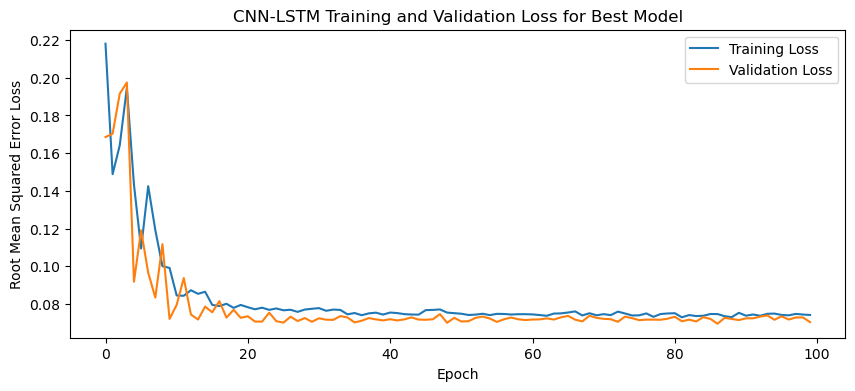

1/1 - 4s - loss: 0.0939 - 4s/epoch - 4s/step
Test Loss: 0.09387656301259995
Fold 2:
Epoch 1/100
19/19 [==============================] - 20s 363ms/step - loss: 0.3030 - val_loss: 0.1008
Epoch 2/100
19/19 [==============================] - 3s 179ms/step - loss: 0.1379 - val_loss: 0.1255
Epoch 3/100
19/19 [==============================] - 3s 146ms/step - loss: 0.1311 - val_loss: 0.1838
Epoch 4/100
19/19 [==============================] - 2s 125ms/step - loss: 0.1794 - val_loss: 0.1415
Epoch 5/100
19/19 [==============================] - 2s 108ms/step - loss: 0.1459 - val_loss: 0.1027
Epoch 6/100
19/19 [==============================] - 2s 109ms/step - loss: 0.1082 - val_loss: 0.0740
Epoch 7/100
19/19 [==============================] - 3s 143ms/step - loss: 0.0994 - val_loss: 0.0705
Epoch 8/100
19/19 [==============================] - 3s 133ms/step - loss: 0.1068 - val_loss: 0.0676
Epoch 9/100
19/19 [==============================] - 2s 125ms/step - loss: 0.0885 - val_loss: 0.0687
Epoch 

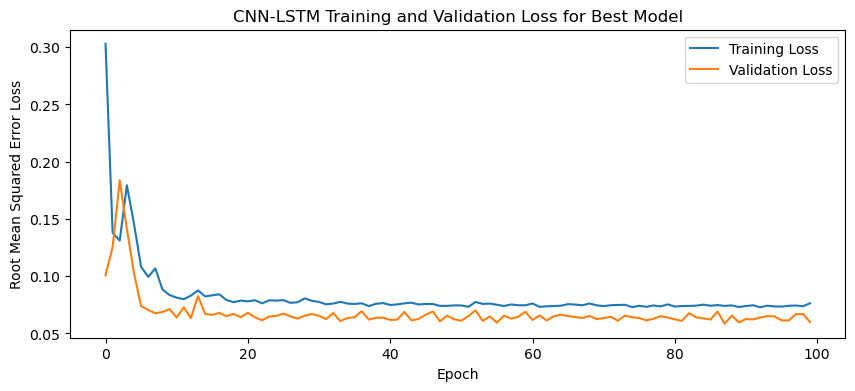

1/1 - 3s - loss: 0.0966 - 3s/epoch - 3s/step
Test Loss: 0.09656546264886856
Fold 3:
Epoch 1/100
19/19 [==============================] - 21s 393ms/step - loss: 0.2705 - val_loss: 0.3213
Epoch 2/100
19/19 [==============================] - 5s 245ms/step - loss: 0.1914 - val_loss: 0.1039
Epoch 3/100
19/19 [==============================] - 3s 184ms/step - loss: 0.1442 - val_loss: 0.0802
Epoch 4/100
19/19 [==============================] - 3s 176ms/step - loss: 0.1538 - val_loss: 0.1038
Epoch 5/100
19/19 [==============================] - 3s 182ms/step - loss: 0.1324 - val_loss: 0.1652
Epoch 6/100
19/19 [==============================] - 3s 177ms/step - loss: 0.1234 - val_loss: 0.0965
Epoch 7/100
19/19 [==============================] - 4s 231ms/step - loss: 0.1193 - val_loss: 0.1125
Epoch 8/100
19/19 [==============================] - 5s 247ms/step - loss: 0.1051 - val_loss: 0.0721
Epoch 9/100
19/19 [==============================] - 4s 224ms/step - loss: 0.0869 - val_loss: 0.0930
Epoch 

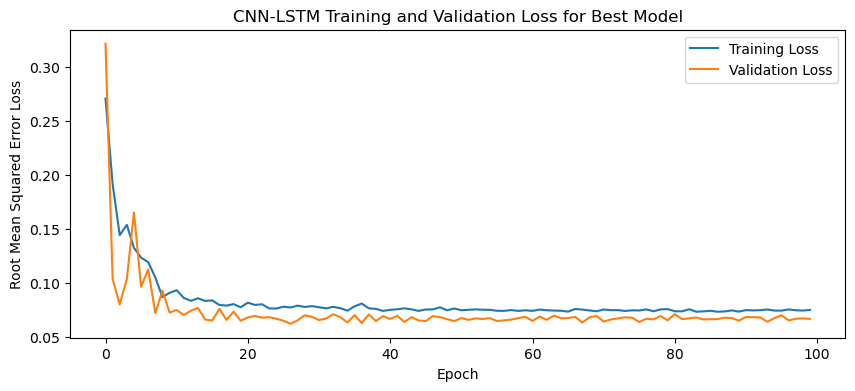

1/1 - 4s - loss: 0.0824 - 4s/epoch - 4s/step
Test Loss: 0.08237168192863464
Fold 4:
Epoch 1/100
20/20 [==============================] - 24s 466ms/step - loss: 0.4533 - val_loss: 0.3159
Epoch 2/100
20/20 [==============================] - 4s 197ms/step - loss: 0.2685 - val_loss: 0.1975
Epoch 3/100
20/20 [==============================] - 5s 261ms/step - loss: 0.1736 - val_loss: 0.1201
Epoch 4/100
20/20 [==============================] - 4s 188ms/step - loss: 0.1599 - val_loss: 0.1072
Epoch 5/100
20/20 [==============================] - 4s 192ms/step - loss: 0.1574 - val_loss: 0.1477
Epoch 6/100
20/20 [==============================] - 5s 228ms/step - loss: 0.1485 - val_loss: 0.1251
Epoch 7/100
20/20 [==============================] - 4s 204ms/step - loss: 0.1464 - val_loss: 0.0745
Epoch 8/100
20/20 [==============================] - 4s 180ms/step - loss: 0.1574 - val_loss: 0.1524
Epoch 9/100
20/20 [==============================] - 4s 208ms/step - loss: 0.1479 - val_loss: 0.0990
Epoch 

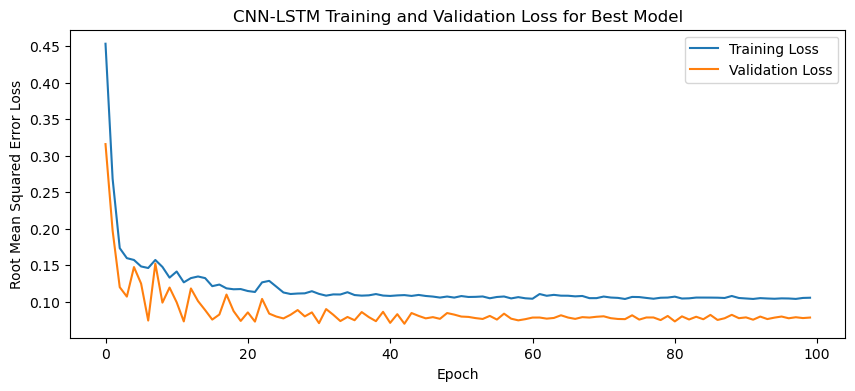

1/1 - 6s - loss: 0.1095 - 6s/epoch - 6s/step
Test Loss: 0.1094779446721077
Fold 5:
Epoch 1/100
19/19 [==============================] - 23s 471ms/step - loss: 0.2261 - val_loss: 0.1815
Epoch 2/100
19/19 [==============================] - 5s 249ms/step - loss: 0.1754 - val_loss: 0.1404
Epoch 3/100
19/19 [==============================] - 4s 200ms/step - loss: 0.1544 - val_loss: 0.1088
Epoch 4/100
19/19 [==============================] - 4s 194ms/step - loss: 0.1481 - val_loss: 0.1948
Epoch 5/100
19/19 [==============================] - 4s 233ms/step - loss: 0.1265 - val_loss: 0.1272
Epoch 6/100
19/19 [==============================] - 3s 177ms/step - loss: 0.1181 - val_loss: 0.1324
Epoch 7/100
19/19 [==============================] - 3s 165ms/step - loss: 0.1059 - val_loss: 0.1015
Epoch 8/100
19/19 [==============================] - 4s 186ms/step - loss: 0.1074 - val_loss: 0.1280
Epoch 9/100
19/19 [==============================] - 4s 196ms/step - loss: 0.1038 - val_loss: 0.1160
Epoch 1

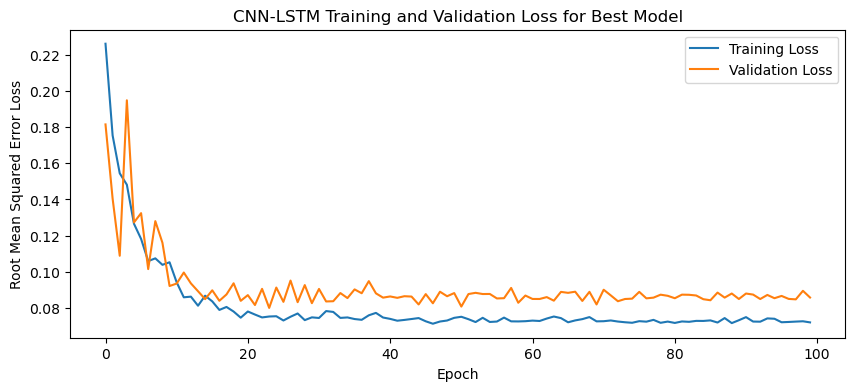

1/1 - 4s - loss: 0.0708 - 4s/epoch - 4s/step
Test Loss: 0.07075639069080353


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

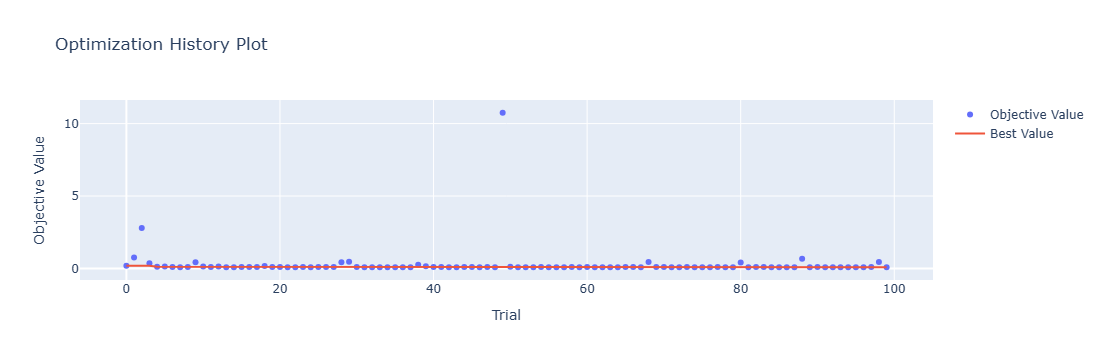

In [4]:
optuna.visualization.plot_optimization_history(study)

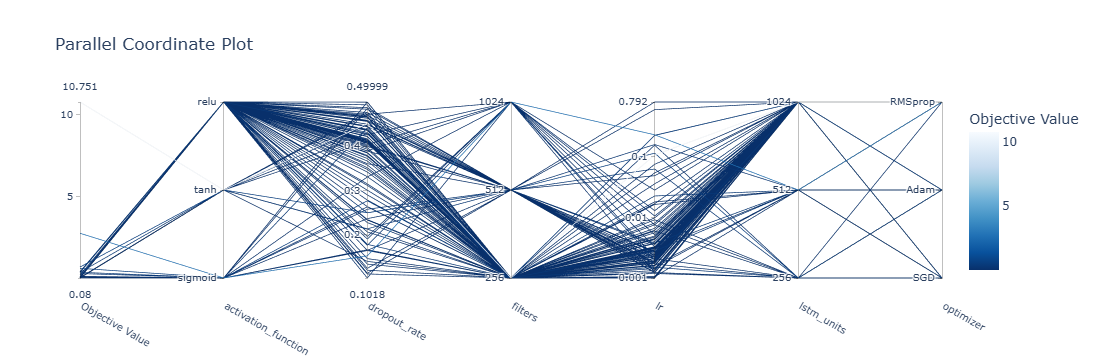

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

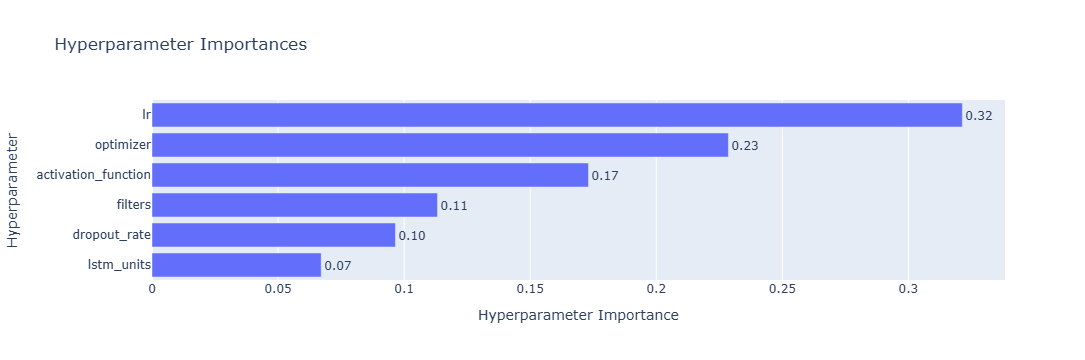

In [6]:
optuna.visualization.plot_param_importances(study)

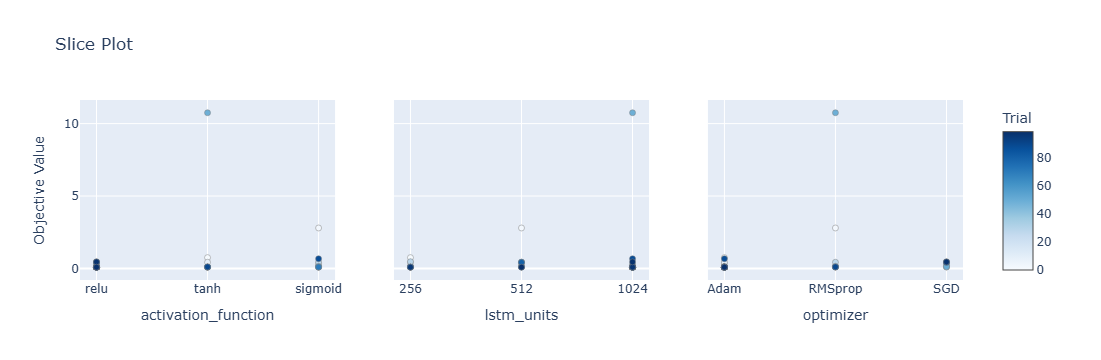

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

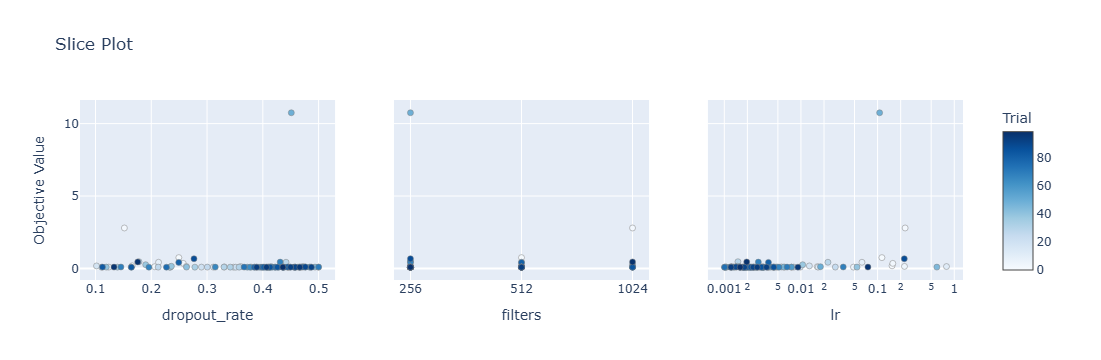

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 33s 594ms/step - loss: 0.2320 - accuracy: 0.1579 - mae: 0.2006 - rmse: 0.2320 - mape: 47.0313 - pearson: 0.1391 - val_loss: 0.2138 - val_accuracy: 0.0000e+00 - val_mae: 0.1915 - val_rmse: 0.2138 - val_mape: 44.1500 - val_pearson: 0.1783
Epoch 2/100
19/19 [==============================] - 4s 194ms/step - loss: 0.1664 - accuracy: 0.2105 - mae: 0.1463 - rmse: 0.1664 - mape: 34.6516 - pearson: 0.2028 - val_loss: 0.1215 - val_accuracy: 0.0000e+00 - val_mae: 0.1029 - val_rmse: 0.1215 - val_mape: 25.2067 - val_pearson: 0.1739
Epoch 3/100
19/19 [==============================] - 4s 206ms/step - loss: 0.2184 

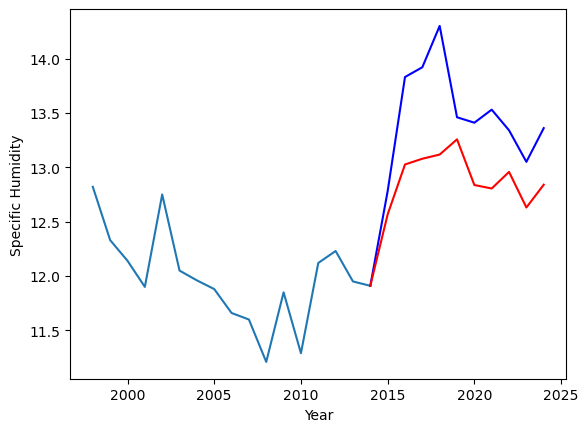

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		9.82		0.11
10.79		10.28		-0.51
10.20		10.33		0.13
10.87		10.37		-0.50
10.99		10.51		-0.48
10.80		10.09		-0.71
11.01		10.05		-0.96
10.57		10.21		-0.36
10.05		9.88		-0.17
10.24		10.09		-0.15


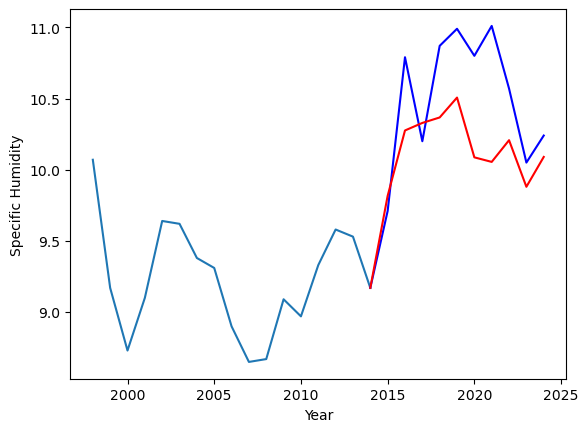

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78  12.566545
1                1    9.71   9.816545


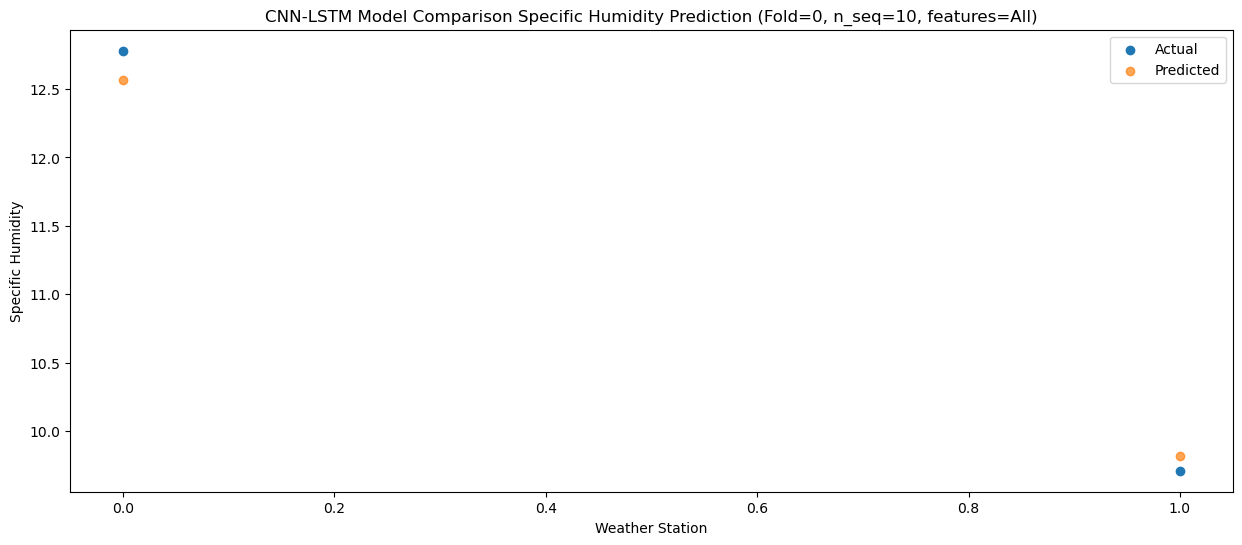

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  13.025738
1                1   10.79  10.275738


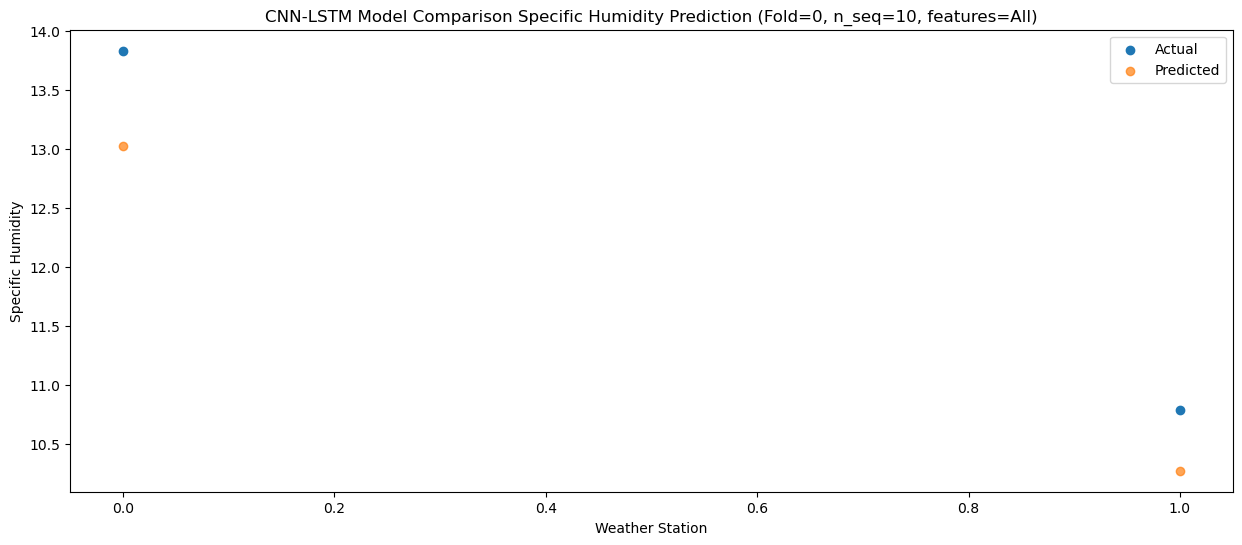

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  13.078603
1                1   10.20  10.328603


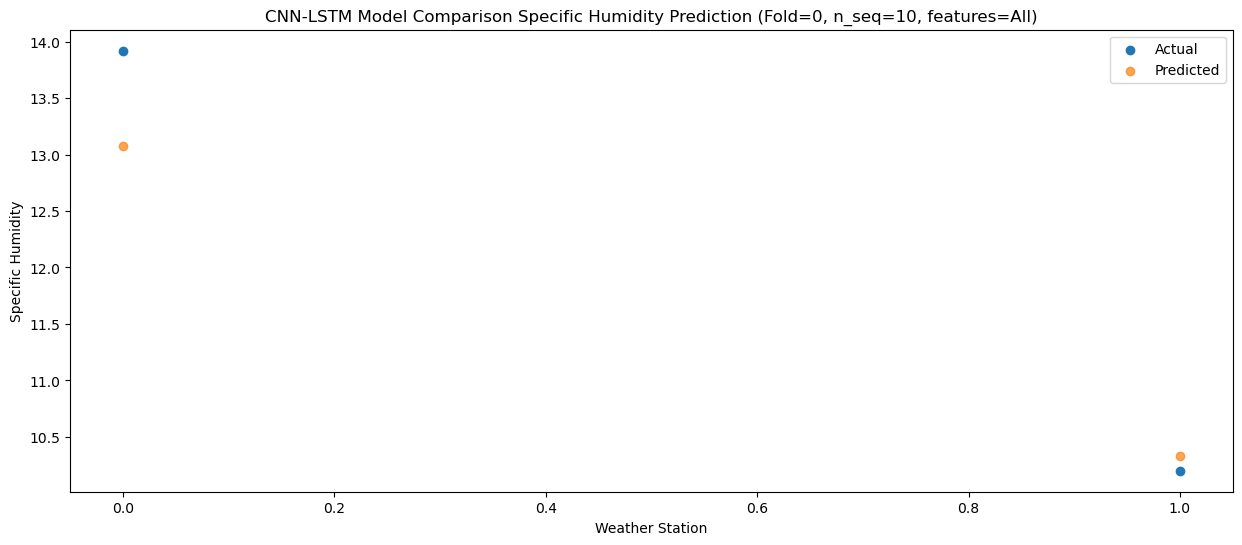

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.117072
1                1   10.87  10.367072


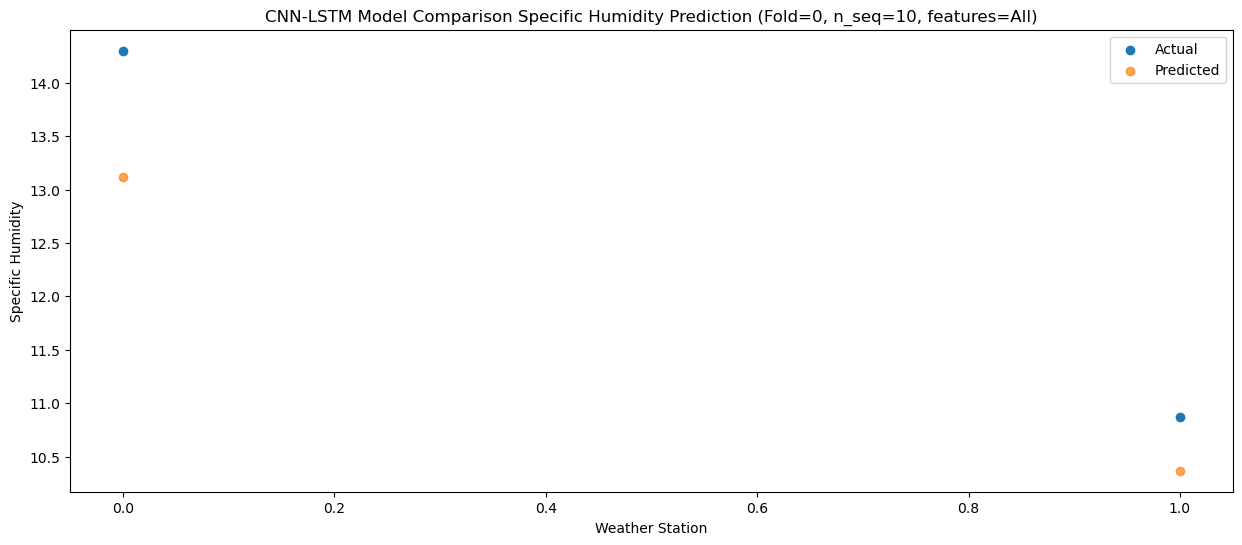

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.256726
1                1   10.99  10.506726


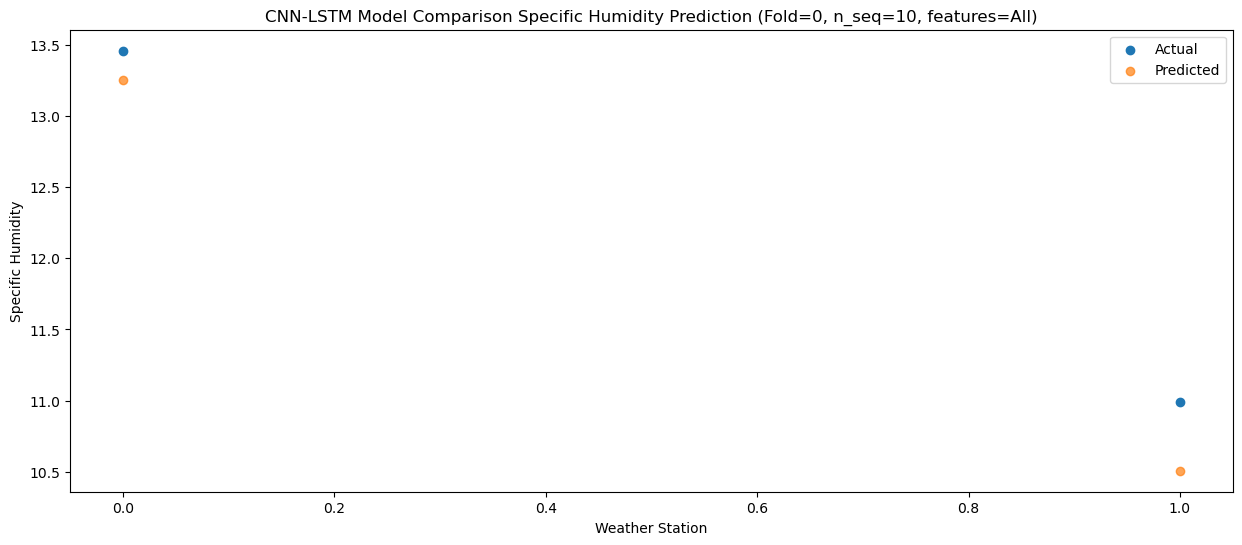

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  12.836853
1                1   10.80  10.086853


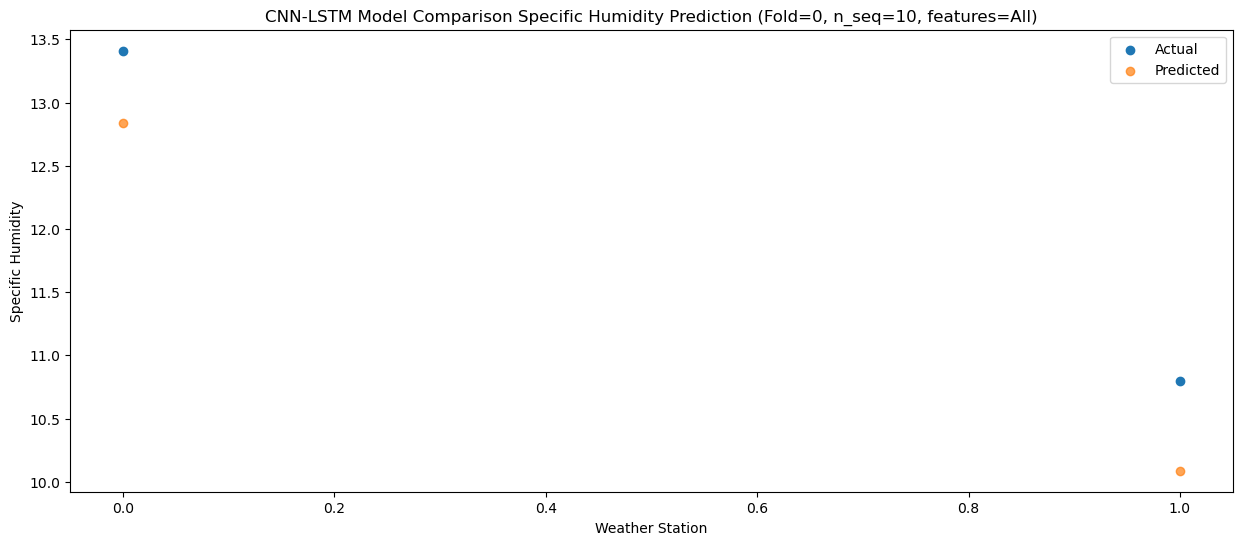

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  12.804872
1                1   11.01  10.054872


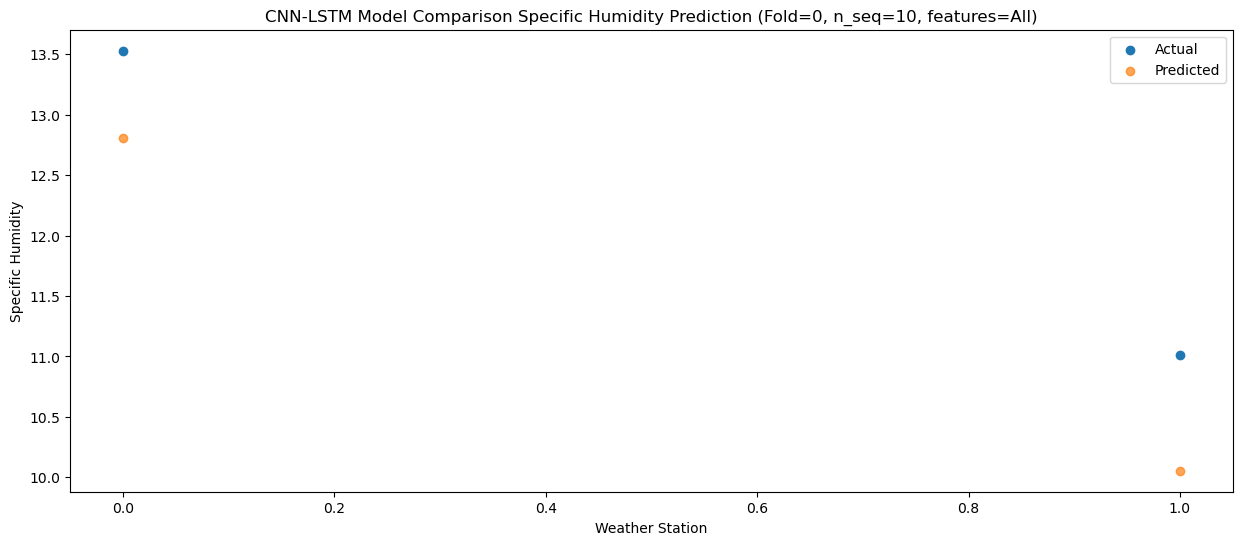

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  12.957371
1                1   10.57  10.207371


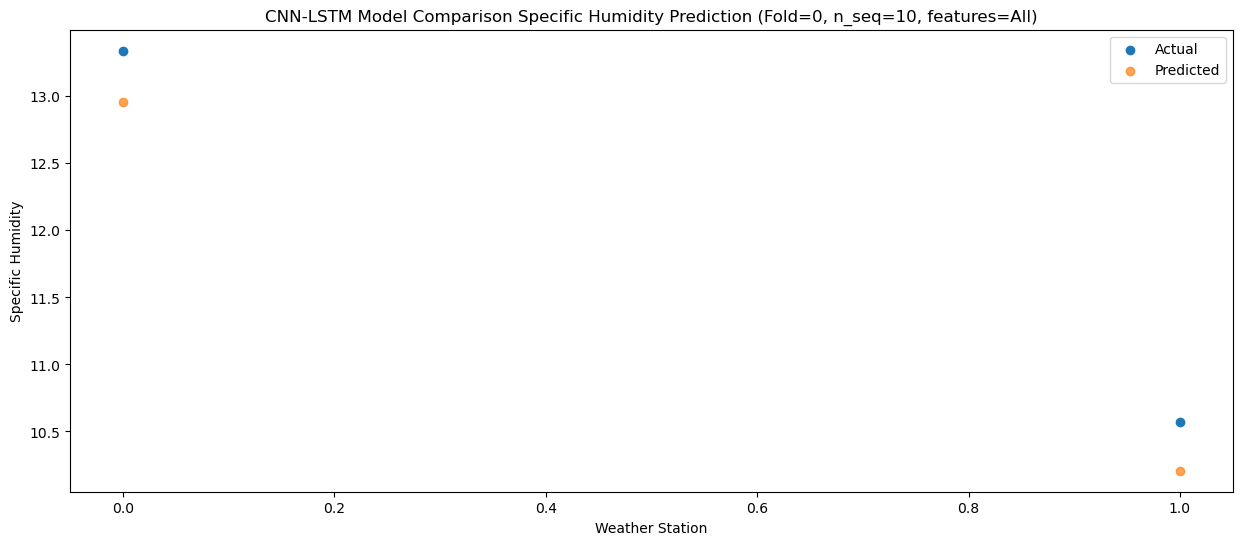

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  12.630051
1                1   10.05   9.880051


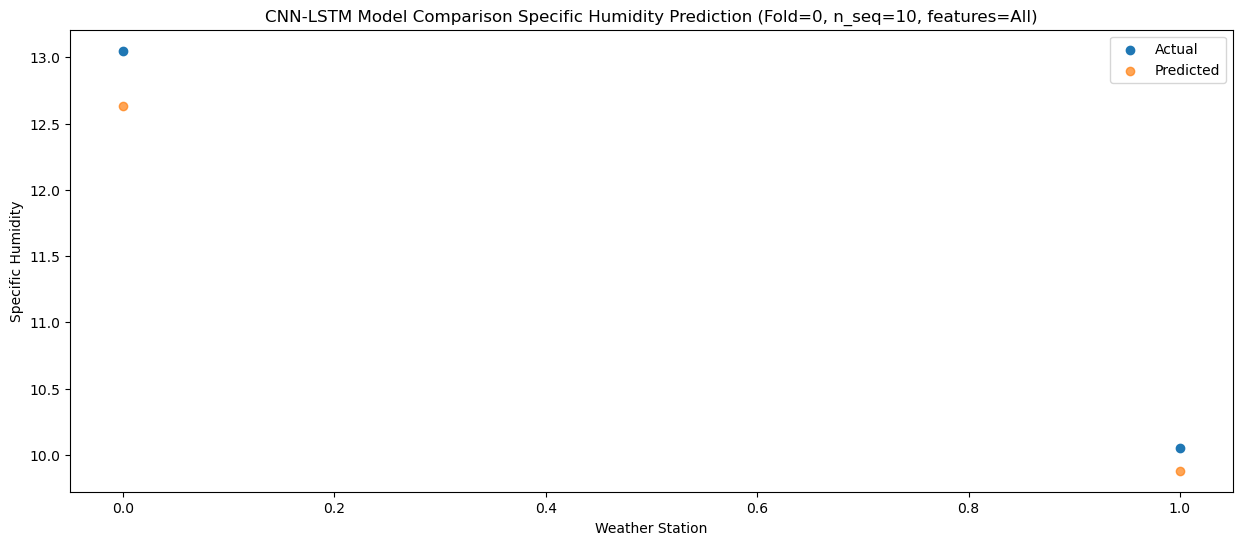

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  12.839823
1                1   10.24  10.089823


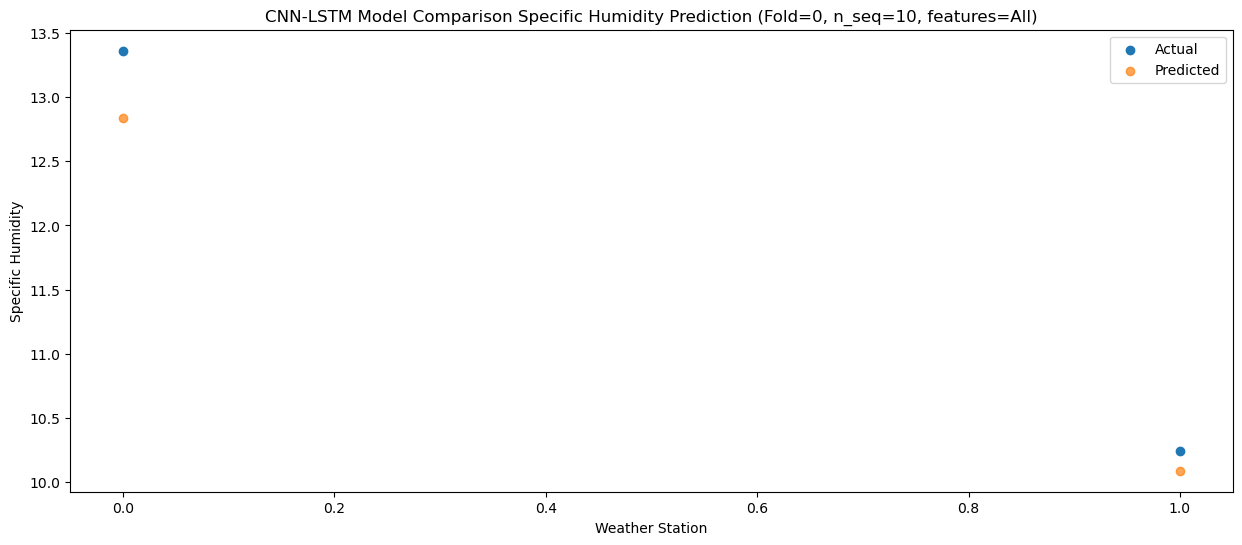

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.56654514  9.81654514]
 [13.02573807 10.27573807]
 [13.07860286 10.32860286]
 [13.11707158 10.36707158]
 [13.2567259  10.5067259 ]
 [12.83685335 10.08685335]
 [12.80487237 10.05487237]
 [12.95737148 10.20737148]
 [12.63005081  9.88005081]
 [12.83982338 10.08982338]]
Year at t+1:
t+1 SKRMSE: 0.168693
t+1 KRMSE: 0.168693
t+1 MAE: 0.160000
t+1 SKMAPE: 0.013837
t+1 R2_SCORE: 0.987922
t+1 KMAPE: 0.013837
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.675019
t+2 KRMSE: 0.675019
t+2 MAE: 0.659262
t+2 SKMAPE: 0.052907
t+2 R2_SCORE: 0.802783
t+2 KMAPE: 0.052907
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.601867
t+3 KRMSE: 0.601867
t+3 MAE: 0.485000
t+3 SKMAPE: 0.036527
t+3 R2_SCORE: 0.895293
t+3 KMAPE: 0.036527
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

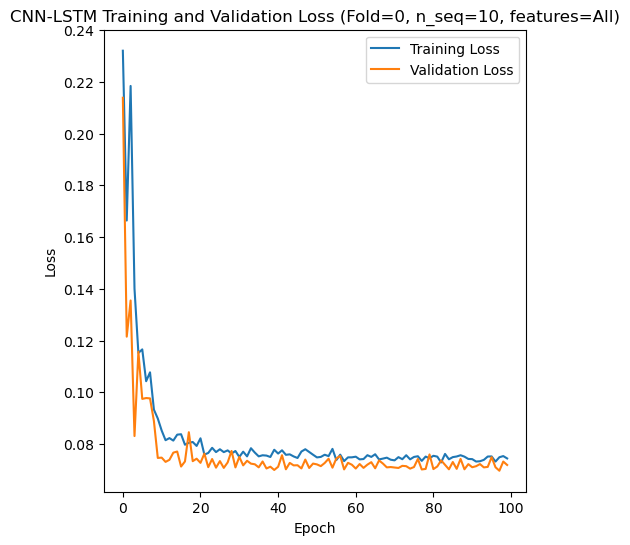

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 40s 650ms/step - loss: 0.2774 - accuracy: 0.2632 - mae: 0.2421 - rmse: 0.2774 - mape: 54.8662 - pearson: 0.1489 - val_loss: 0.2277 - val_accuracy: 0.3333 - val_mae: 0.1991 - val_rmse: 0.2277 - val_mape: 45.8804 - val_pearson: 0.3087
Epoch 2/100
19/19 [==============================] - 4s 190ms/step - loss: 0.2030 - accuracy: 0.2105 - mae: 0.1748 - rmse: 0.2030 - mape: 39.9373 - pearson: 0.1454 - val_loss: 0.1568 - val_accuracy: 0.0000e+00 - val_mae: 0.1144 - val_rmse: 0.1568 - val_mape: 23.8178 - val_pearson: 0.0255
Epoch 3/100
19/19 [==============================] - 3s 182ms/step - loss: 0.1396 - ac

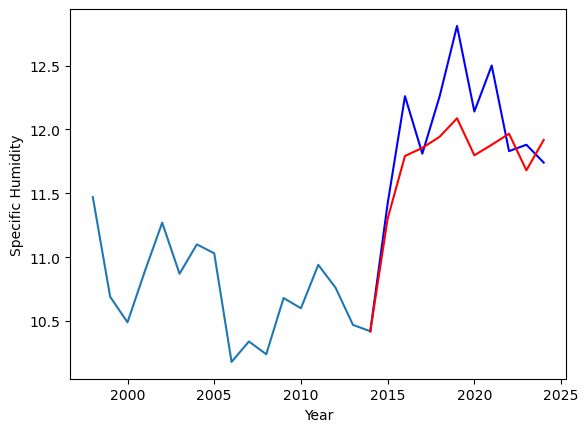

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.46		-0.49
9.08		7.95		-1.13
9.06		8.02		-1.04
8.69		8.10		-0.59
8.53		8.25		-0.28
8.56		7.96		-0.60
7.82		8.04		0.22
8.26		8.13		-0.13
7.69		7.84		0.15
7.84		8.08		0.24


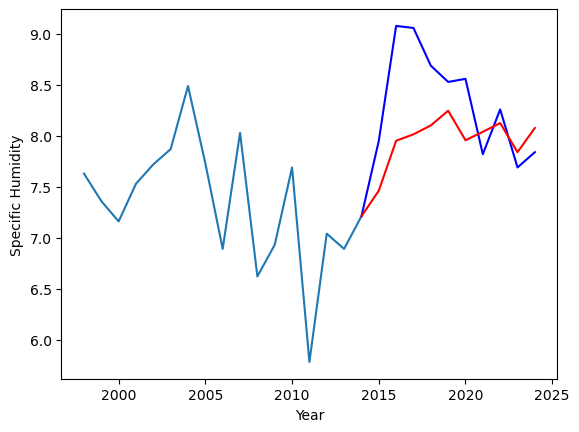

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.301706
1                1    7.95   7.461706


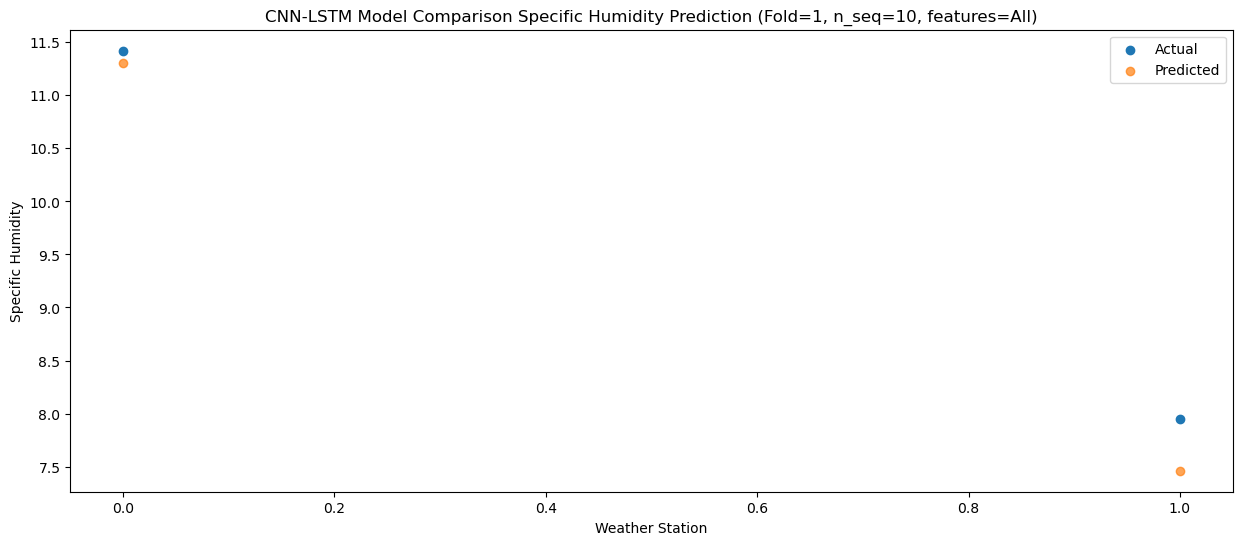

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  11.792138
1                1    9.08   7.952138


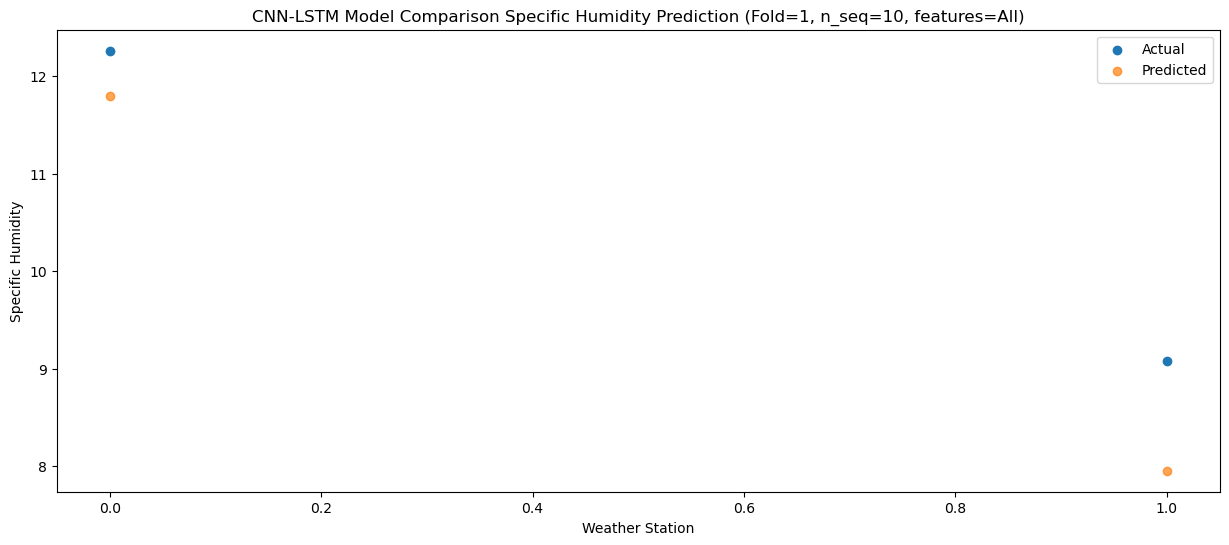

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  11.855397
1                1    9.06   8.015397


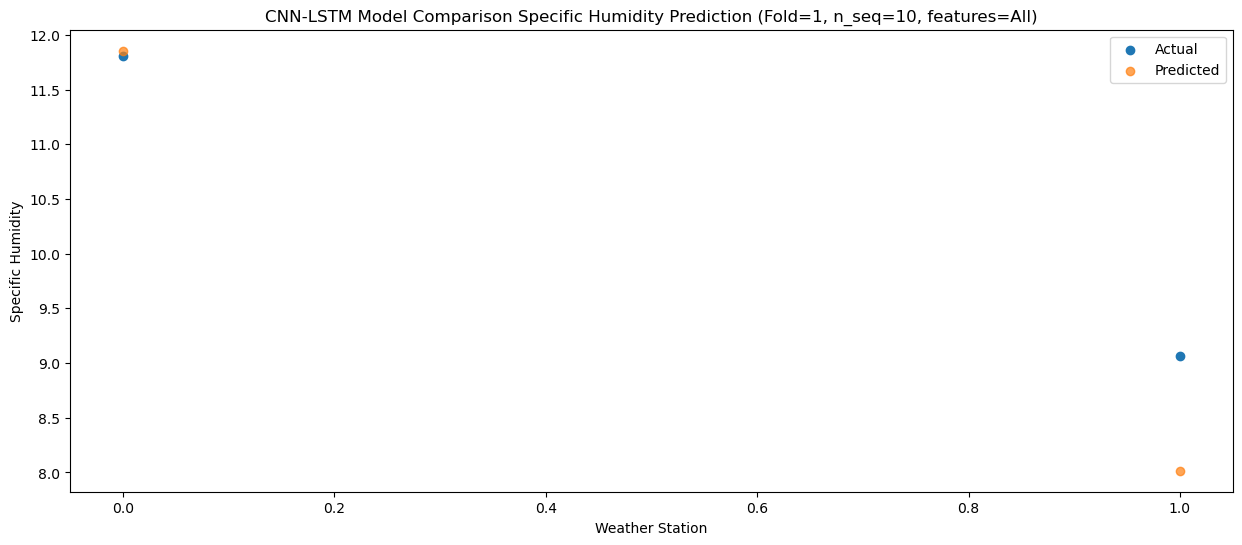

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26   11.94259
1                1    8.69    8.10259


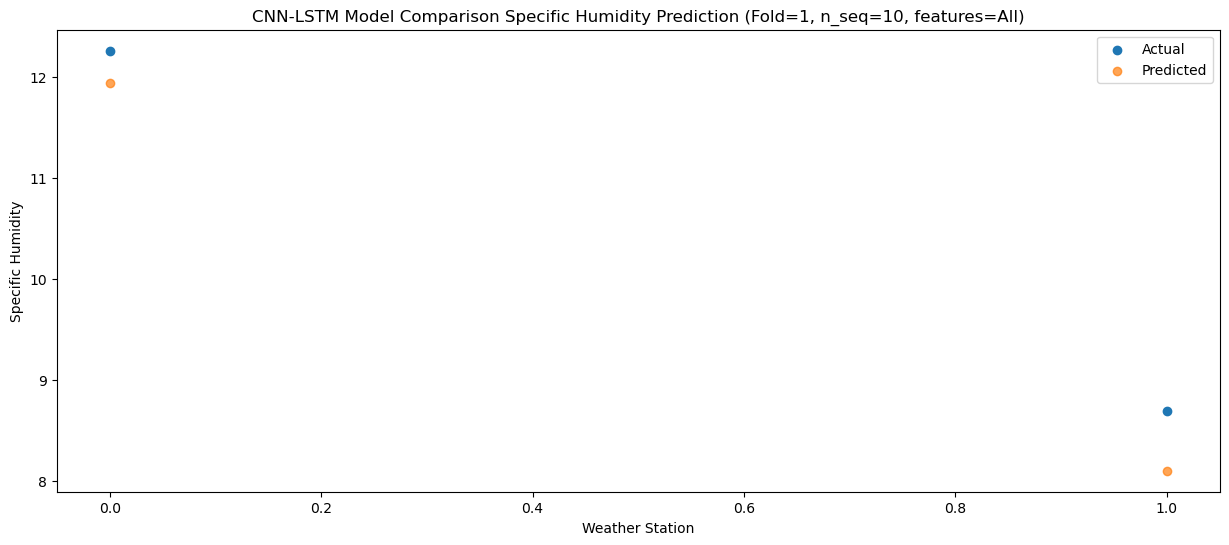

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  12.087088
1                1    8.53   8.247088


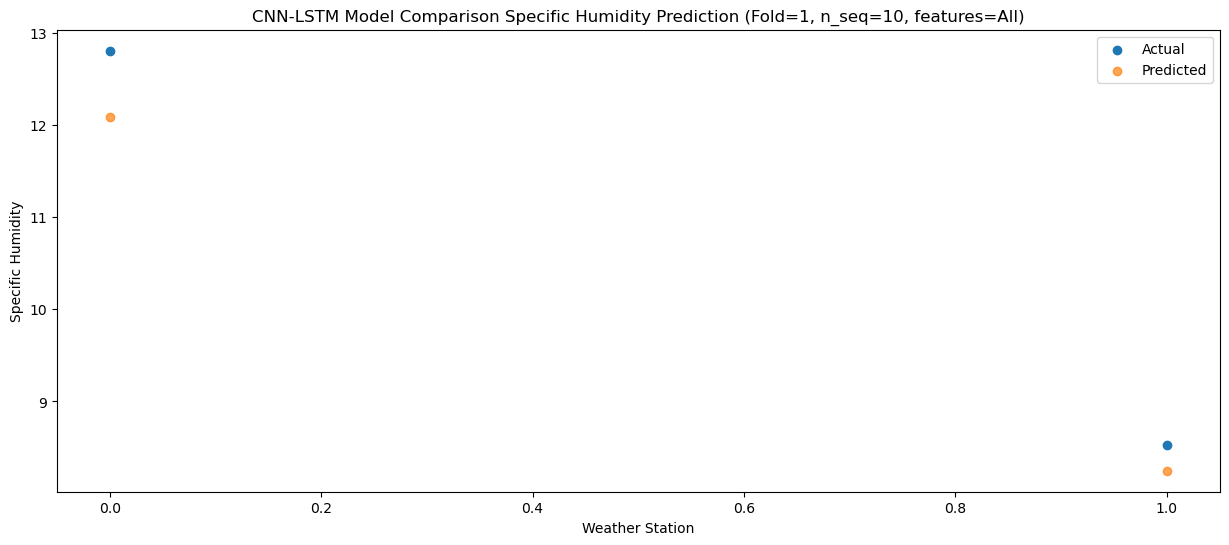

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.797368
1                1    8.56   7.957368


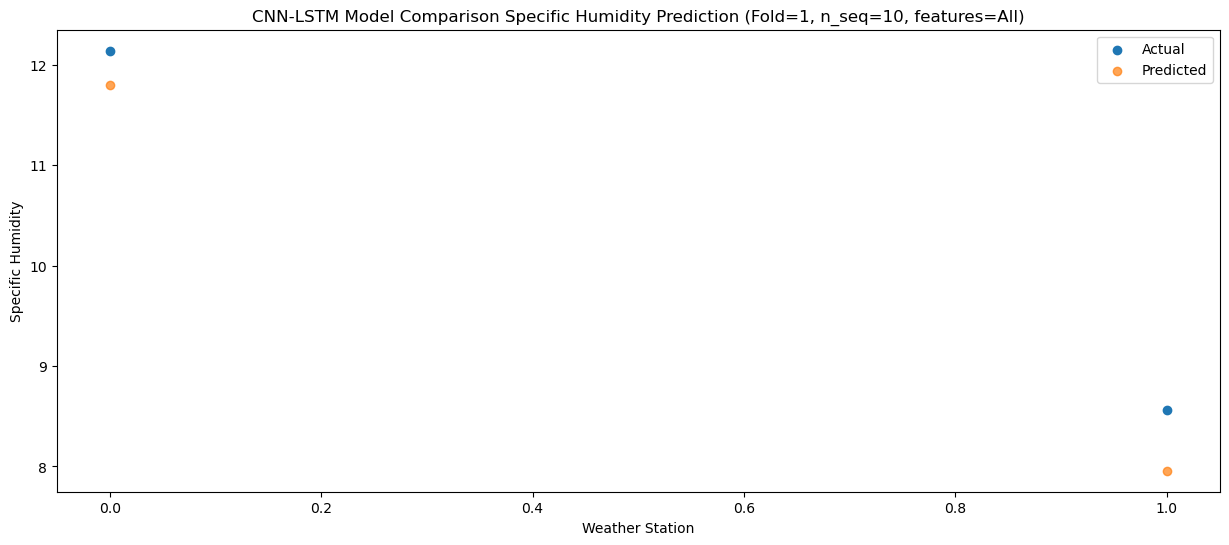

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  11.879759
1                1    7.82   8.039759


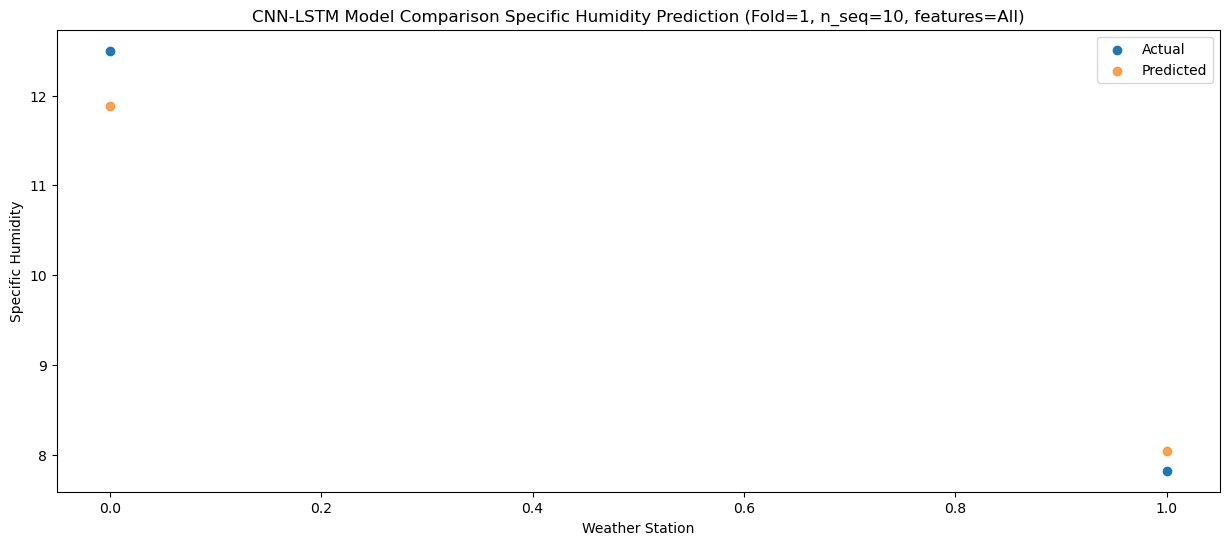

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  11.966056
1                1    8.26   8.126056


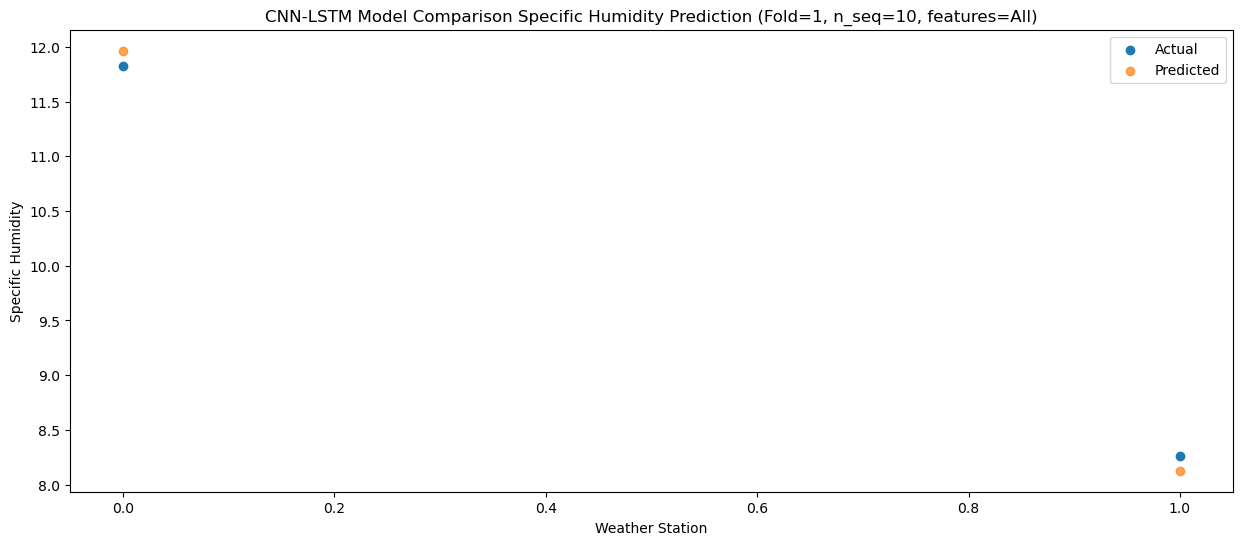

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.679889
1                1    7.69   7.839889


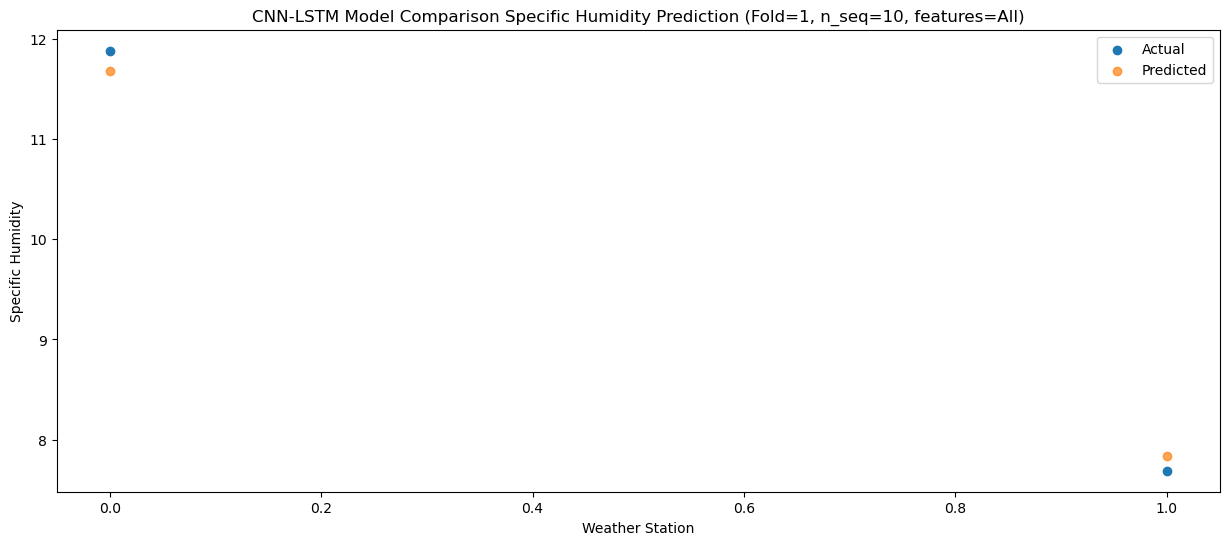

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.917786
1                1    7.84   8.077786


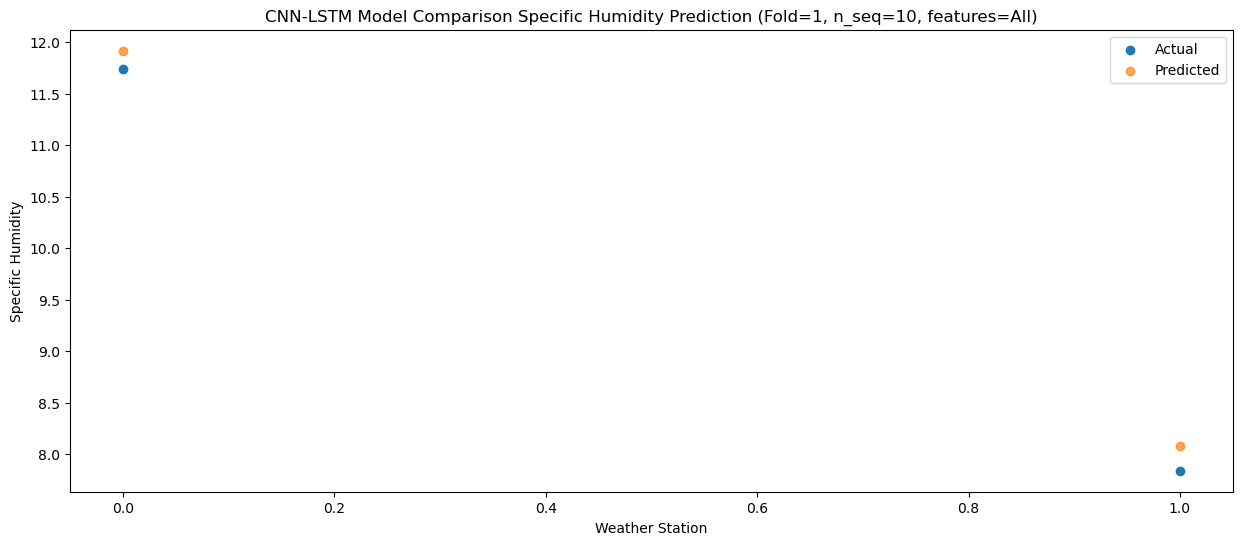

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.30170551  7.46170551]
 [11.79213798  7.95213798]
 [11.85539708  8.01539708]
 [11.94258997  8.10258997]
 [12.08708832  8.24708832]
 [11.7973679   7.9573679 ]
 [11.87975937  8.03975937]
 [11.96605572  8.12605572]
 [11.67988947  7.83988947]
 [11.91778629  8.07778629]]
Year at t+1:
t+1 SKRMSE: 0.355264
t+1 KRMSE: 0.355264
t+1 MAE: 0.303294
t+1 SKMAPE: 0.035890
t+1 R2_SCORE: 0.958072
t+1 KMAPE: 0.035890
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 0.863414
t+2 KRMSE: 0.863414
t+2 MAE: 0.797862
t+2 SKMAPE: 0.081188
t+2 R2_SCORE: 0.705121
t+2 KMAPE: 0.081188
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 0.739343
t+3 KRMSE: 0.739343
t+3 MAE: 0.545000
t+3 SKMAPE: 0.059571
t+3 R2_SCORE: 0.710874
t+3 KMAPE: 0.059571
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

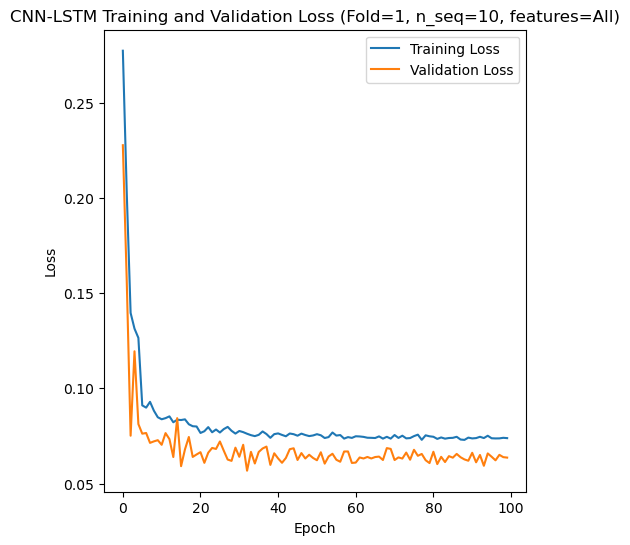

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 23s 347ms/step - loss: 0.2923 - accuracy: 0.3158 - mae: 0.2636 - rmse: 0.2923 - mape: 60.2935 - pearson: 0.1336 - val_loss: 0.1972 - val_accuracy: 0.3333 - val_mae: 0.1672 - val_rmse: 0.1972 - val_mape: 42.2384 - val_pearson: 0.1876
Epoch 2/100
19/19 [==============================] - 3s 155ms/step - loss: 0.1555 - accuracy: 0.2632 - mae: 0.1302 - rmse: 0.1555 - mape: 30.5703 - pearson: 0.1191 - val_loss: 0.1420 - val_accuracy: 0.0000e+00 - val_mae: 0.1161 - val_rmse: 0.1420 - val_mape: 30.6602 - val_pearson: 0.0591
Epoch 3/100
19/19 [==============================] - 2s 115ms/step - loss: 0.1755 - ac

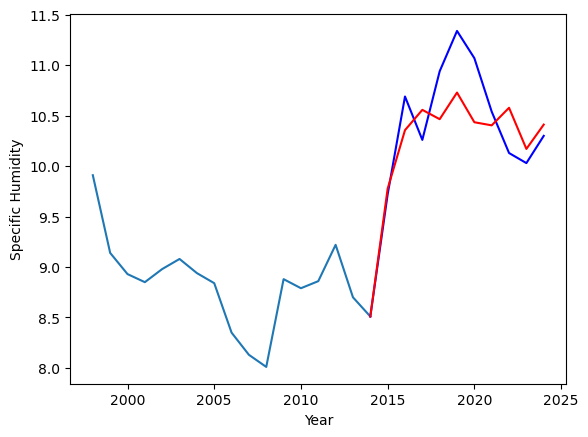

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.36		0.68
8.43		8.94		0.51
8.98		9.14		0.16
8.93		9.05		0.12
9.03		9.31		0.28
8.38		9.01		0.63
8.20		8.98		0.78
8.27		9.16		0.89
8.54		8.75		0.21
8.55		8.99		0.44


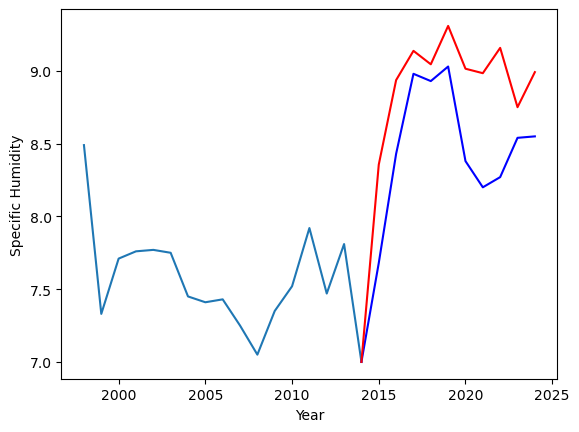

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72   9.776075
1                1    7.68   8.356075


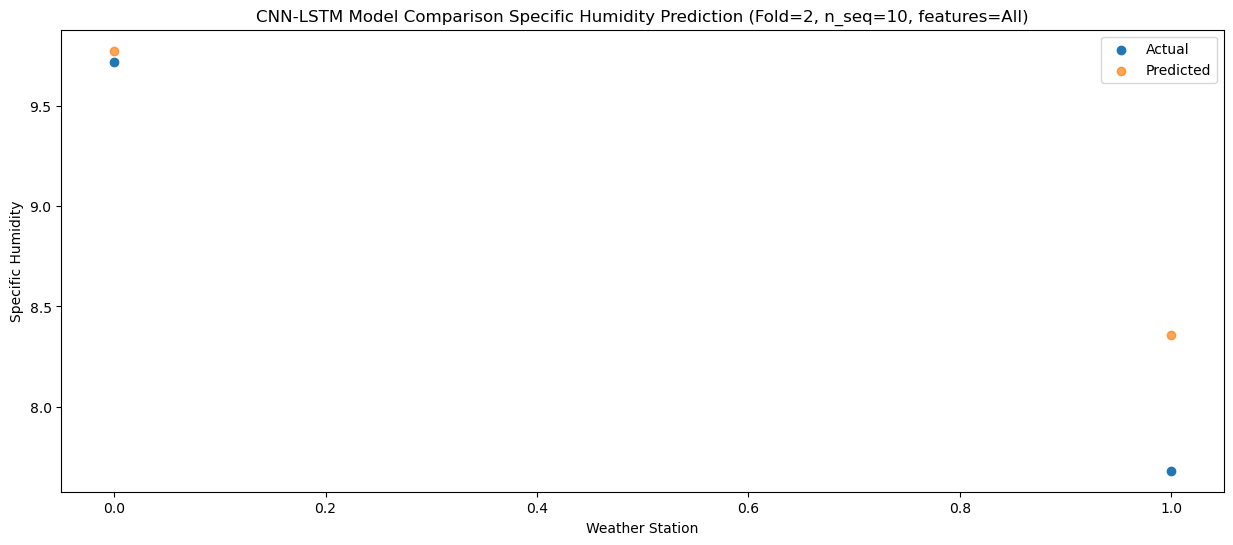

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.356617
1                1    8.43   8.936617


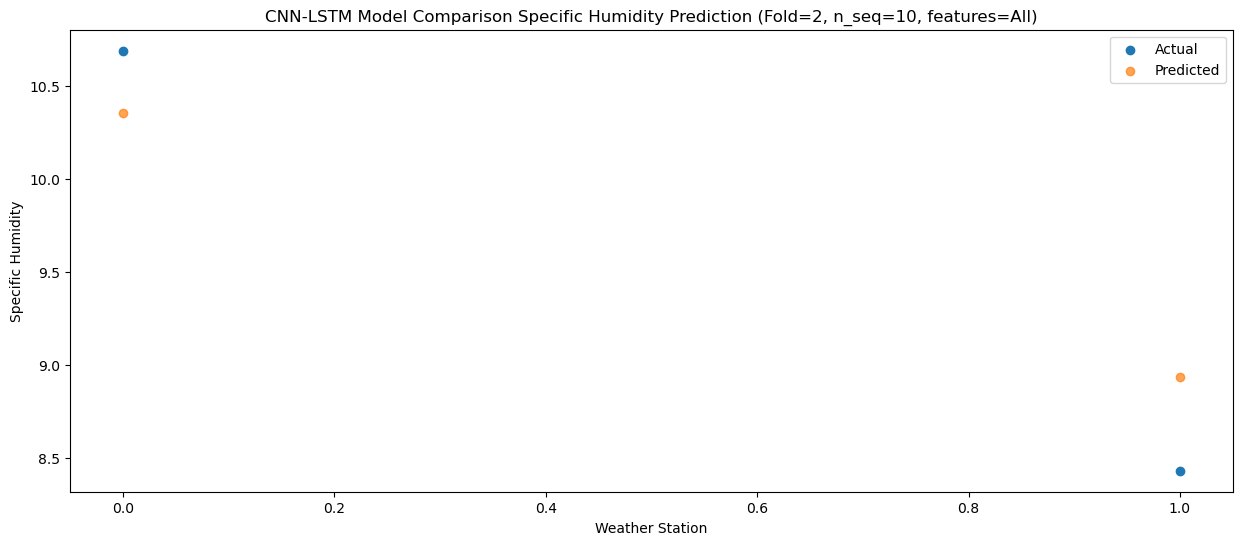

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.557762
1                1    8.98   9.137762


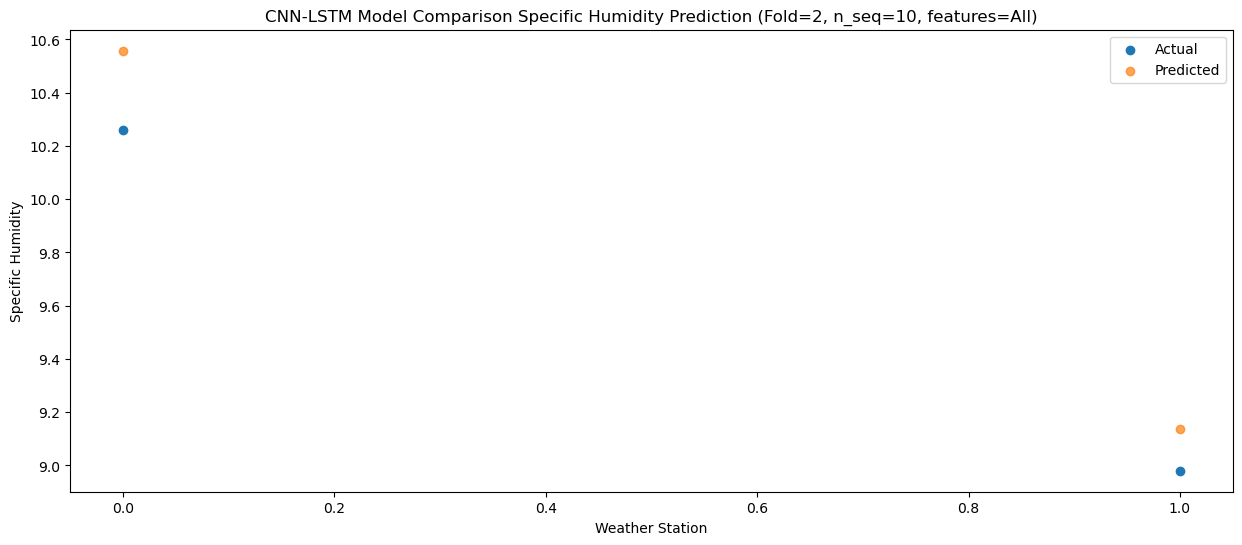

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.465316
1                1    8.93   9.045316


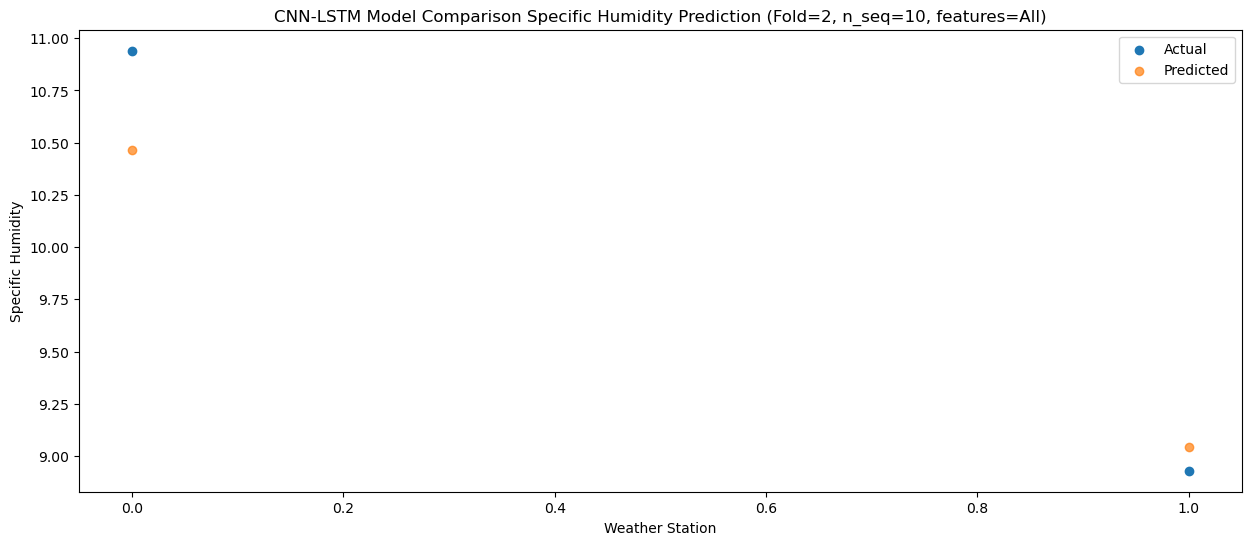

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.729054
1                1    9.03   9.309054


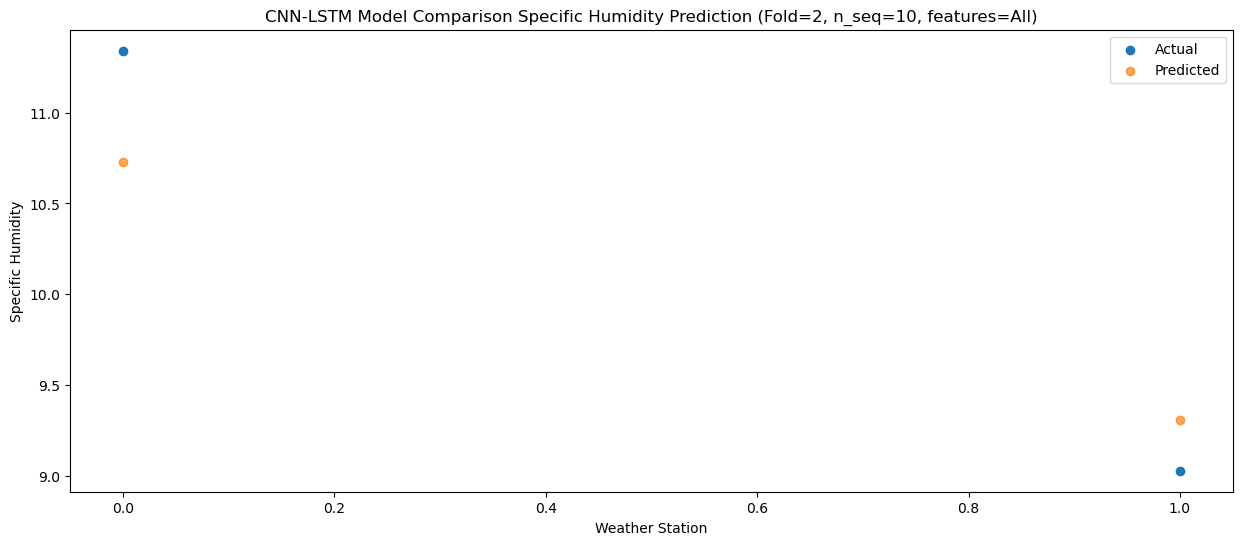

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.434951
1                1    8.38   9.014951


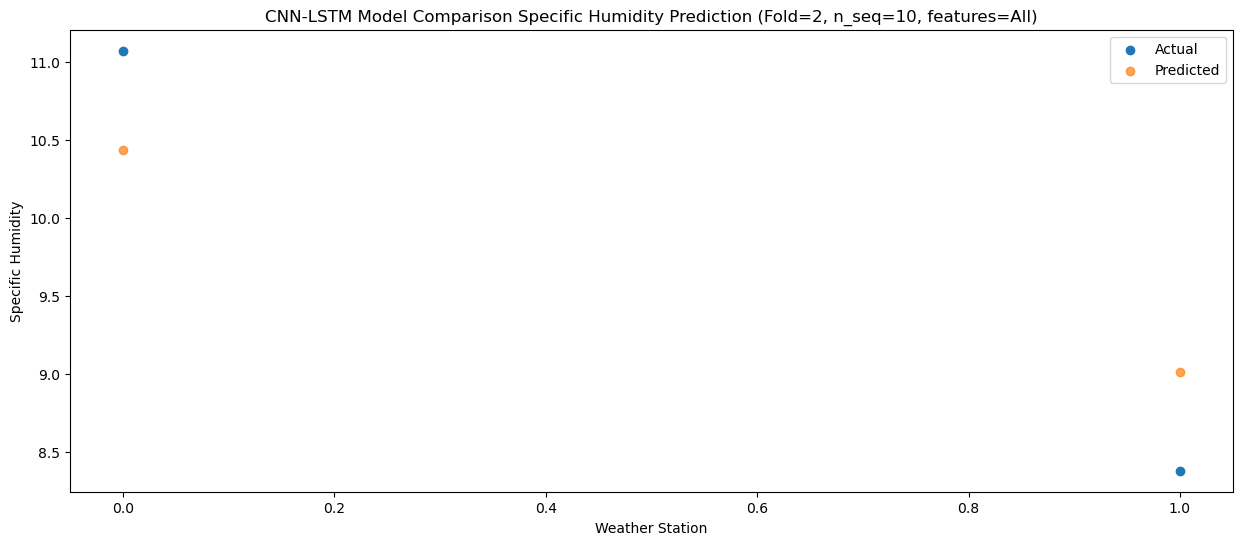

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.404187
1                1    8.20   8.984187


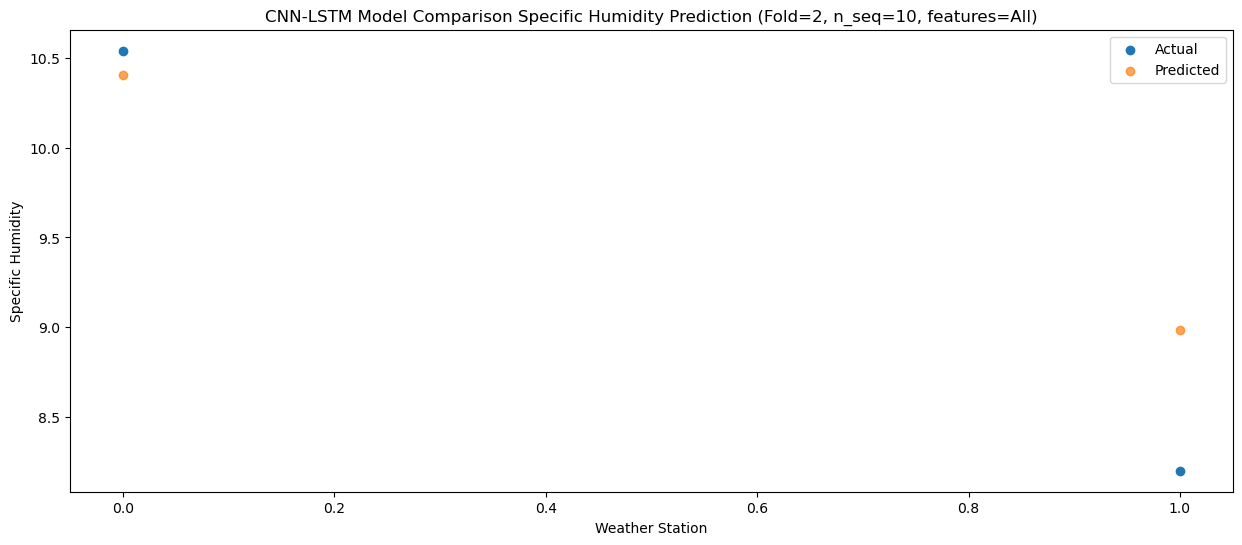

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.578209
1                1    8.27   9.158209


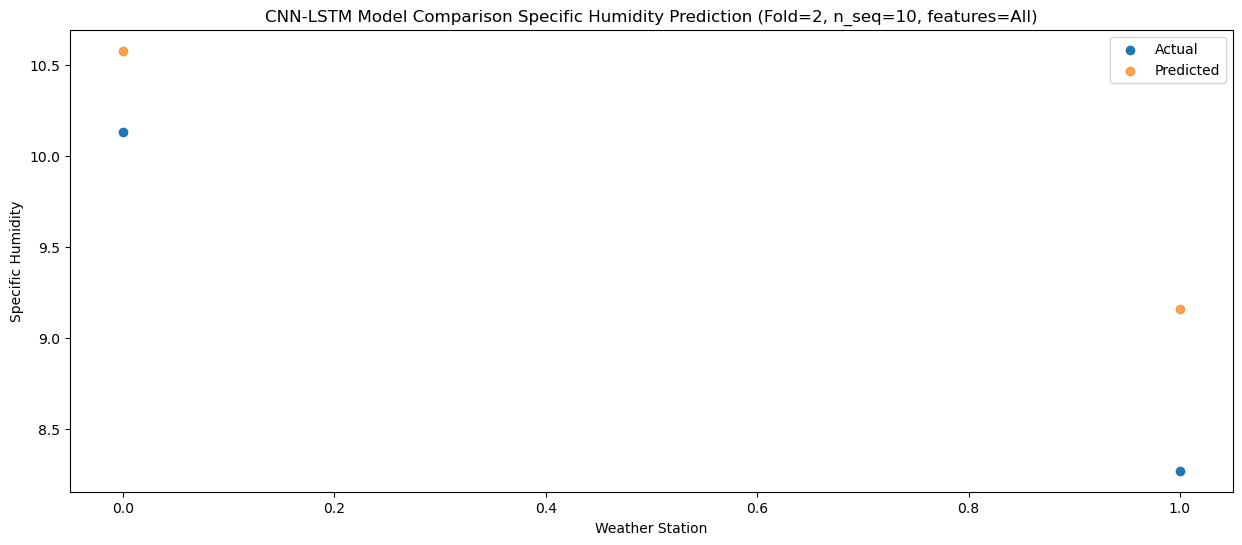

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03  10.170577
1                1    8.54   8.750577


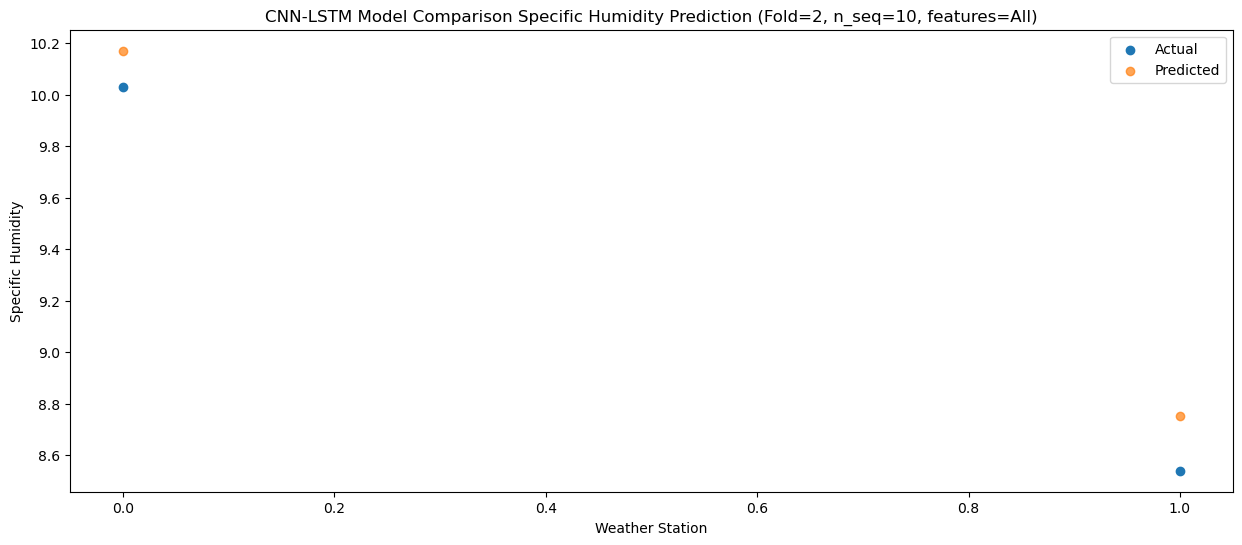

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.411549
1                1    8.55   8.991549


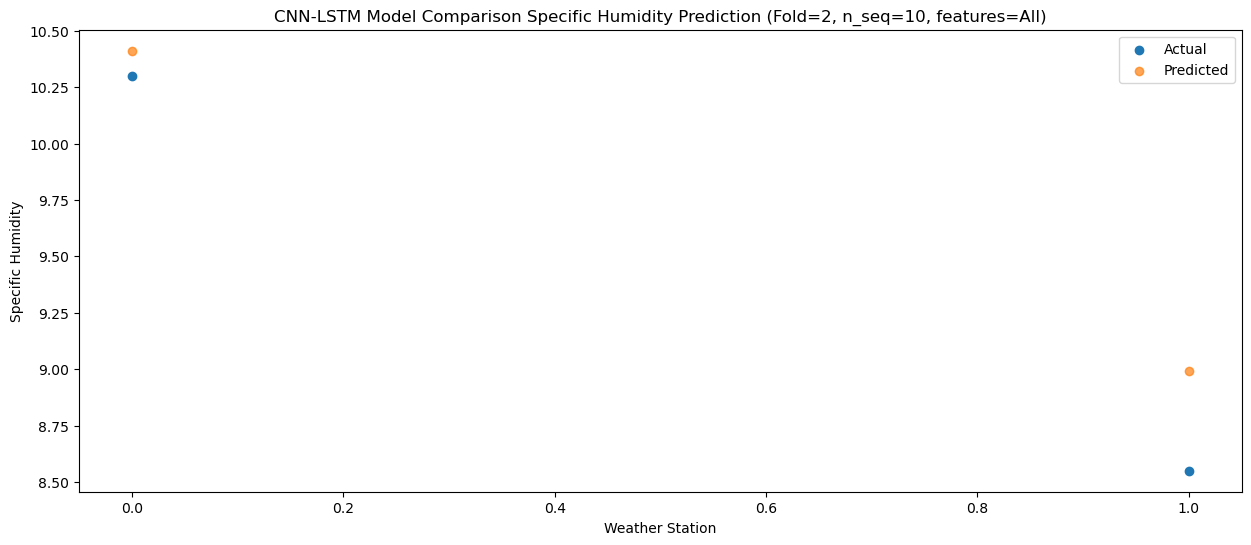

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[ 9.77607522  8.35607522]
 [10.35661683  8.93661683]
 [10.55776197  9.13776197]
 [10.46531628  9.04531628]
 [10.72905431  9.30905431]
 [10.43495078  9.01495078]
 [10.40418736  8.98418736]
 [10.57820926  9.15820926]
 [10.17057738  8.75057738]
 [10.41154876  8.99154876]]
Year at t+1:
t+1 SKRMSE: 0.479699
t+1 KRMSE: 0.479699
t+1 MAE: 0.366075
t+1 SKMAPE: 0.046900
t+1 R2_SCORE: 0.778824
t+1 KMAPE: 0.046900
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.428839
t+2 KRMSE: 0.428839
t+2 MAE: 0.420000
t+2 SKMAPE: 0.045642
t+2 R2_SCORE: 0.855977
t+2 KMAPE: 0.045642
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.238276
t+3 KRMSE: 0.238276
t+3 MAE: 0.227762
t+3 SKMAPE: 0.023295
t+3 R2_SCORE: 0.861388
t+3 KMAPE: 0.023295
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

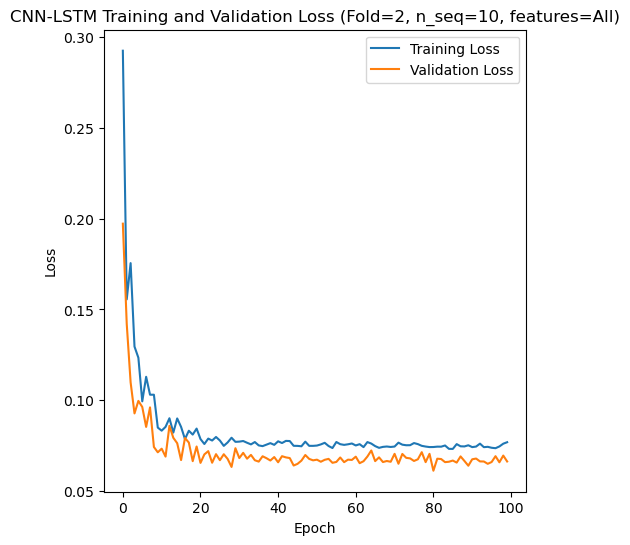

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 29s 546ms/step - loss: 0.3081 - accuracy: 0.2500 - mae: 0.2718 - rmse: 0.3081 - mape: 44.7968 - pearson: 0.1713 - val_loss: 0.2819 - val_accuracy: 0.0000e+00 - val_mae: 0.2436 - val_rmse: 0.2819 - val_mape: 40.5370 - val_pearson: 0.3144
Epoch 2/100
20/20 [==============================] - 3s 139ms/step - loss: 0.2471 - accuracy: 0.3000 - mae: 0.2156 - rmse: 0.2471 - mape: 35.6475 - pearson: 0.2491 - val_loss: 0.2482 - val_accuracy: 0.5000 - val_mae: 0.1988 - val_rmse: 0.2482 - val_mape: 34.7174 - val_pearson: 0.0203
Epoch 3/100
20/20 [==============================] - 3s 145ms/step - loss: 0.2208 - accuracy: 0.3000 - mae: 0.1907 - rmse: 0.2208 - mape: 31.716

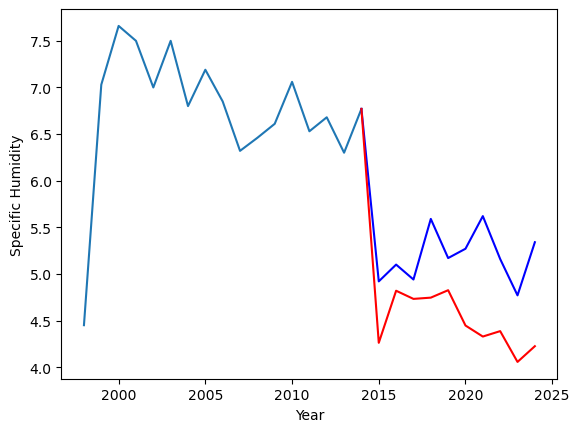

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		8.14		0.19
8.59		8.70		0.11
8.69		8.61		-0.08
8.51		8.63		0.12
8.87		8.71		-0.16
8.75		8.33		-0.42
8.66		8.21		-0.45
8.63		8.27		-0.36
8.16		7.94		-0.22
8.18		8.11		-0.07


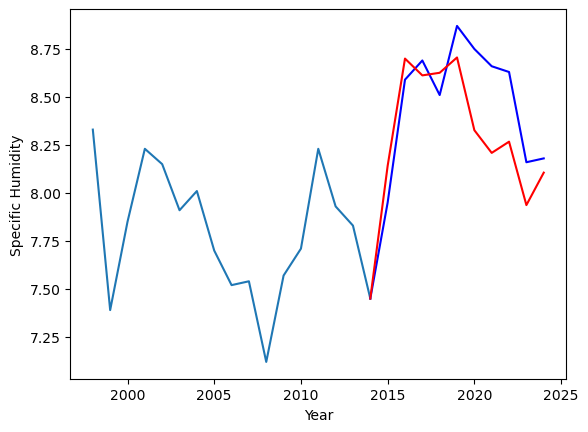

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.260882
1                1    7.95   8.141018


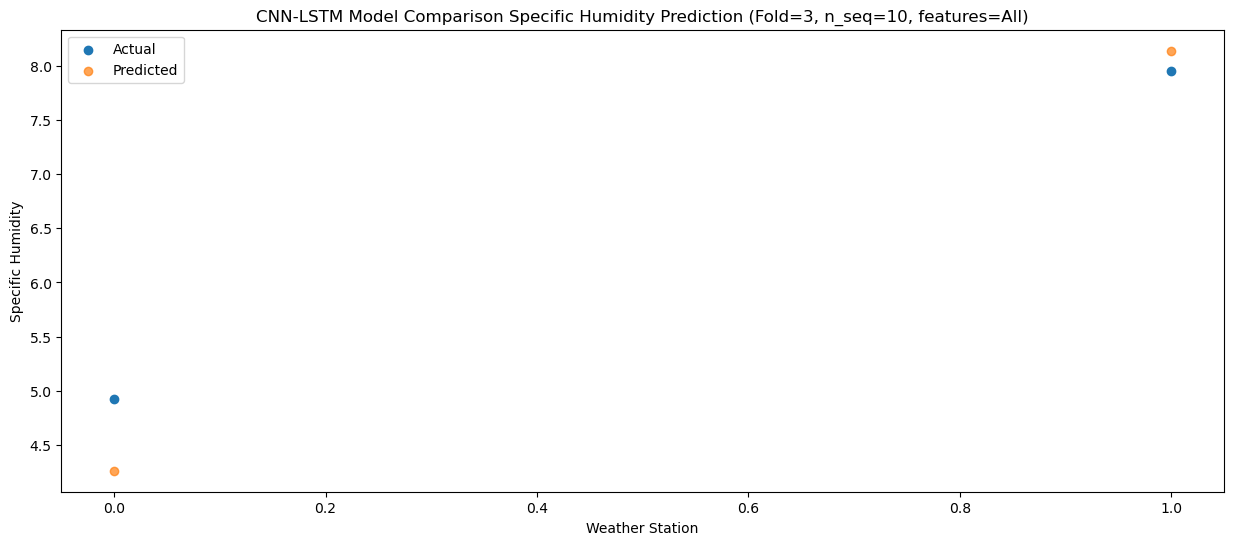

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   4.819593
1                1    8.59   8.699878


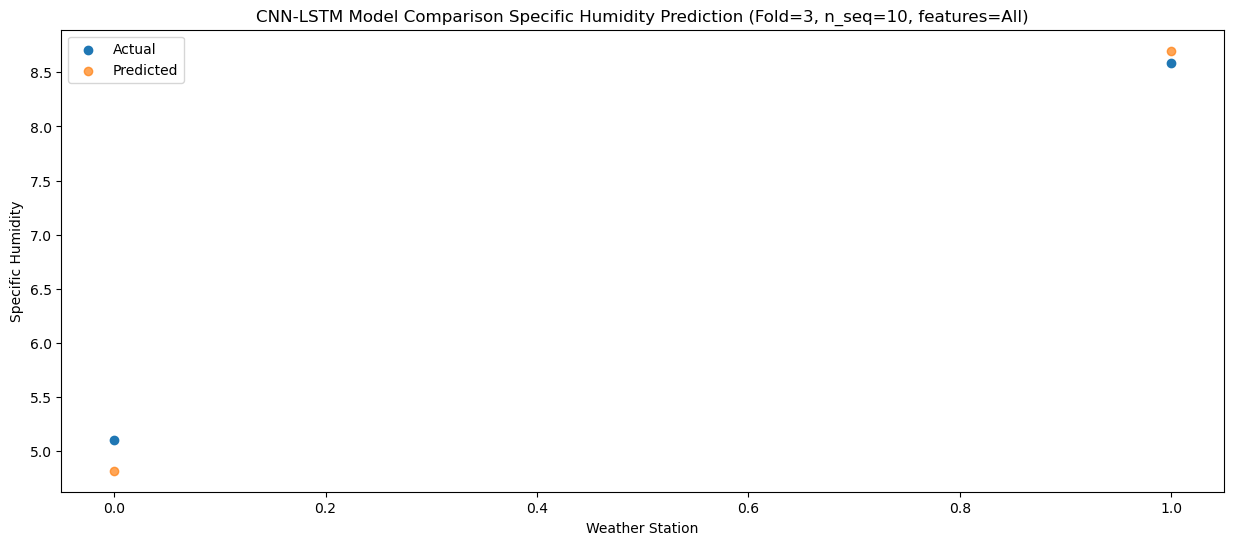

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.732089
1                1    8.69   8.612373


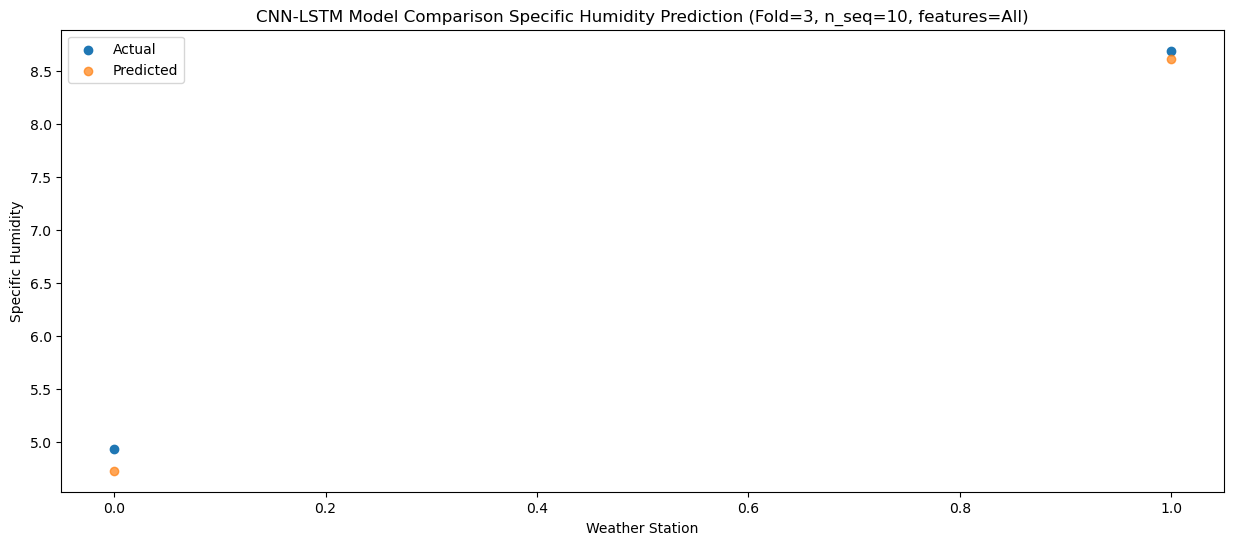

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.745532
1                1    8.51   8.625929


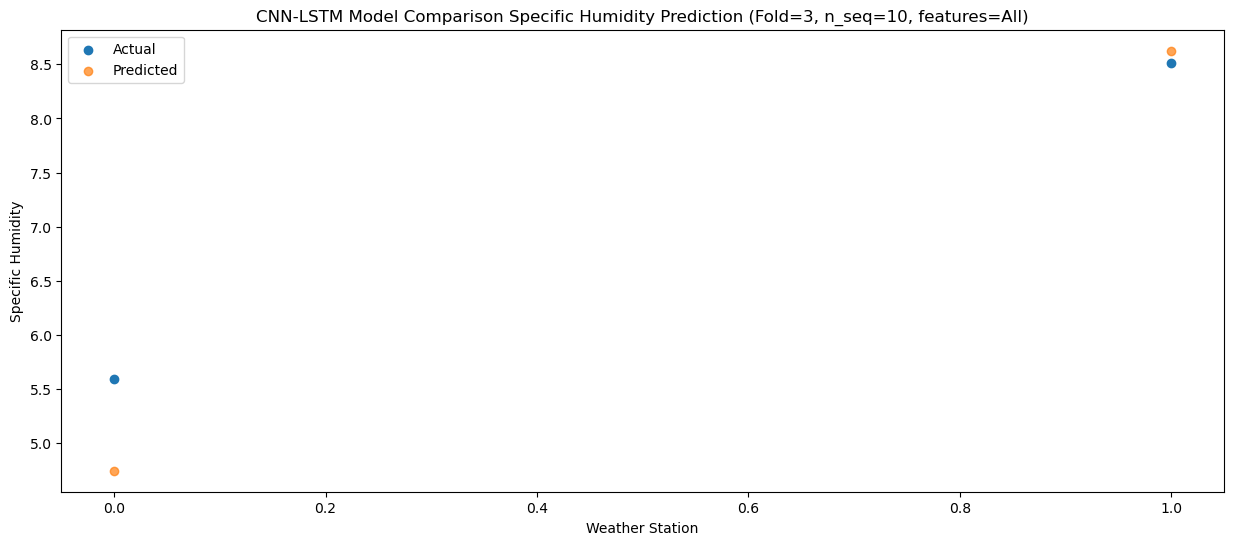

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17    4.82524
1                1    8.87    8.70569


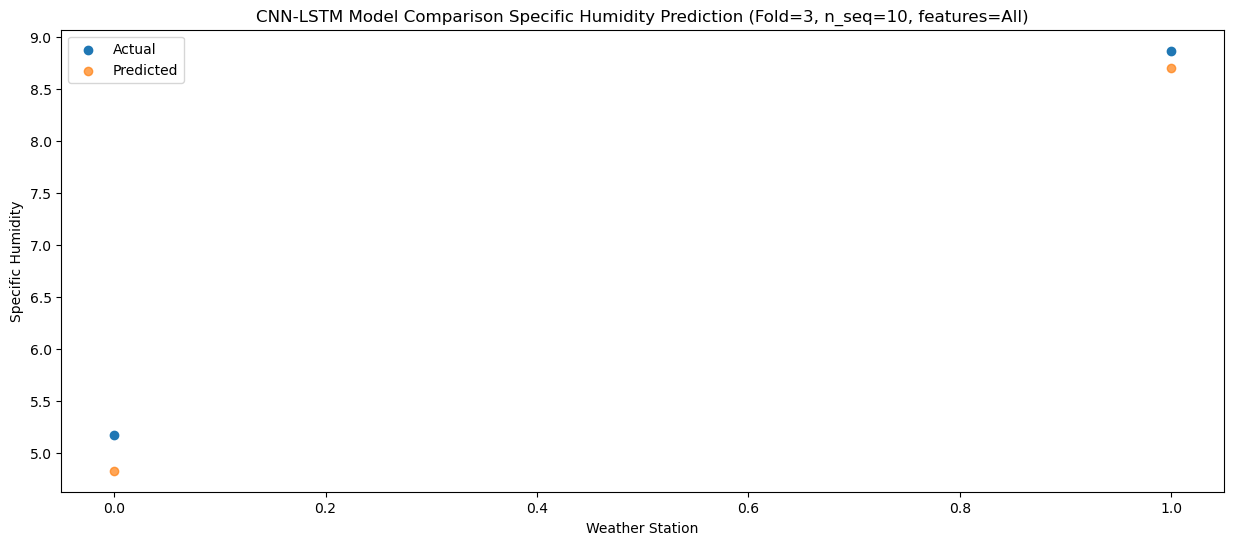

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.446457
1                1    8.75   8.326837


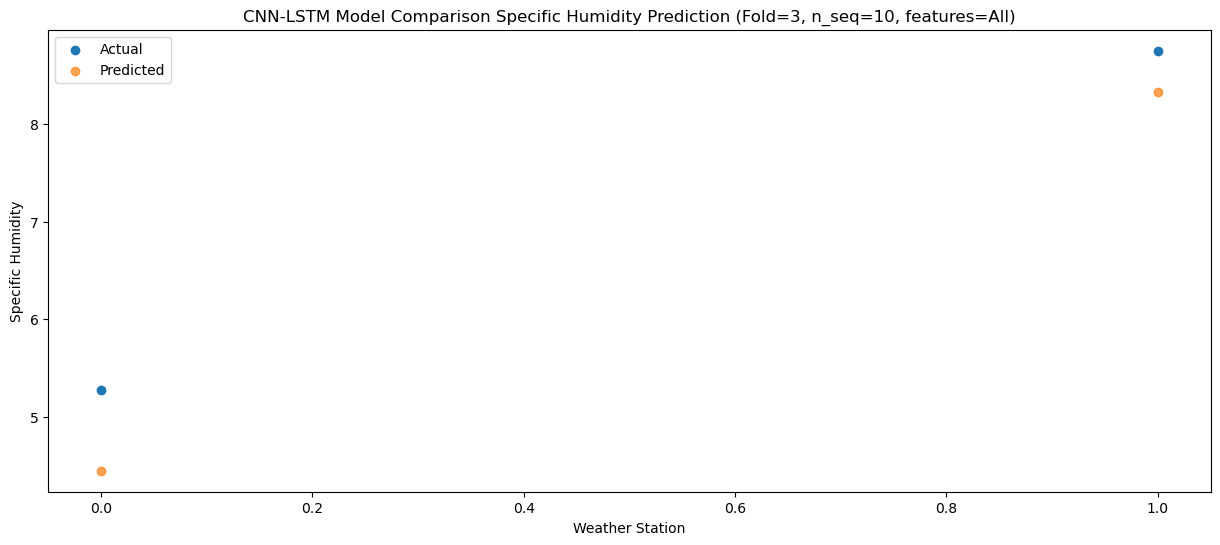

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.328178
1                1    8.66   8.208718


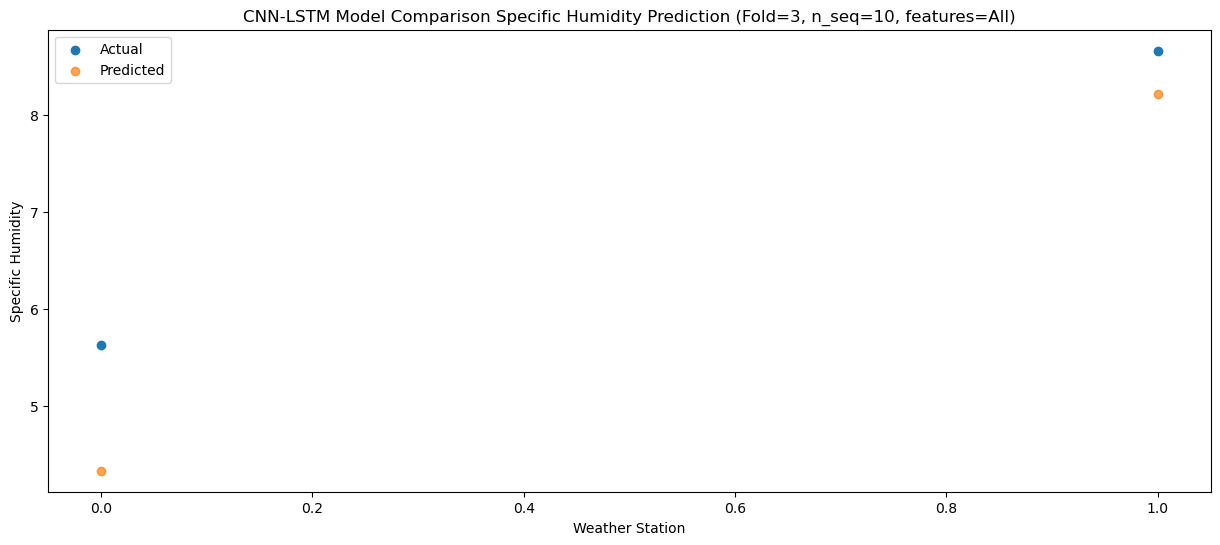

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.386326
1                1    8.63   8.267086


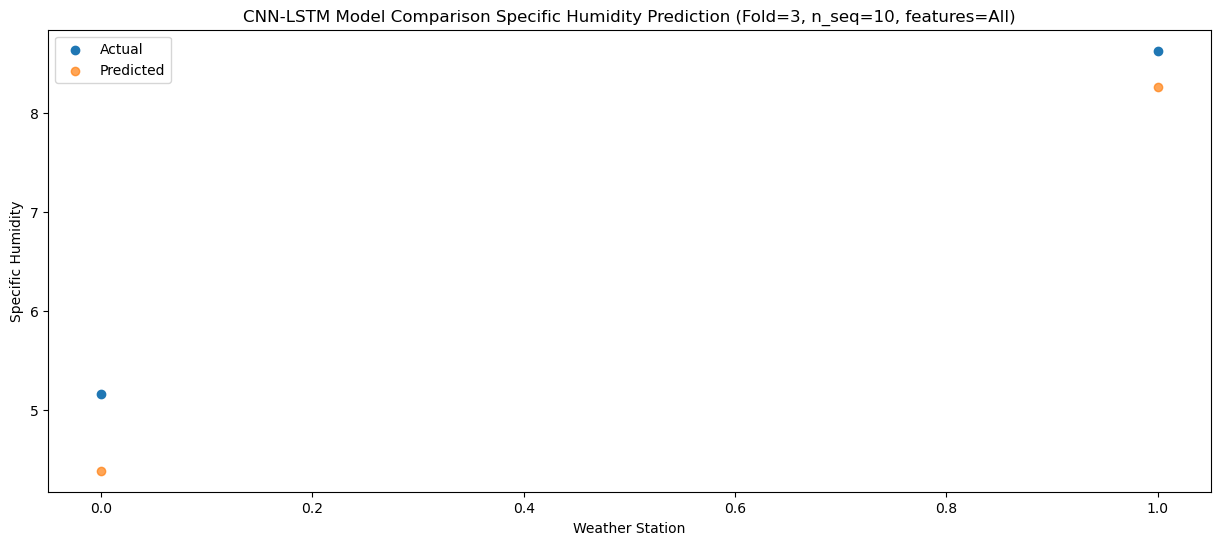

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.056008
1                1    8.16   7.936840


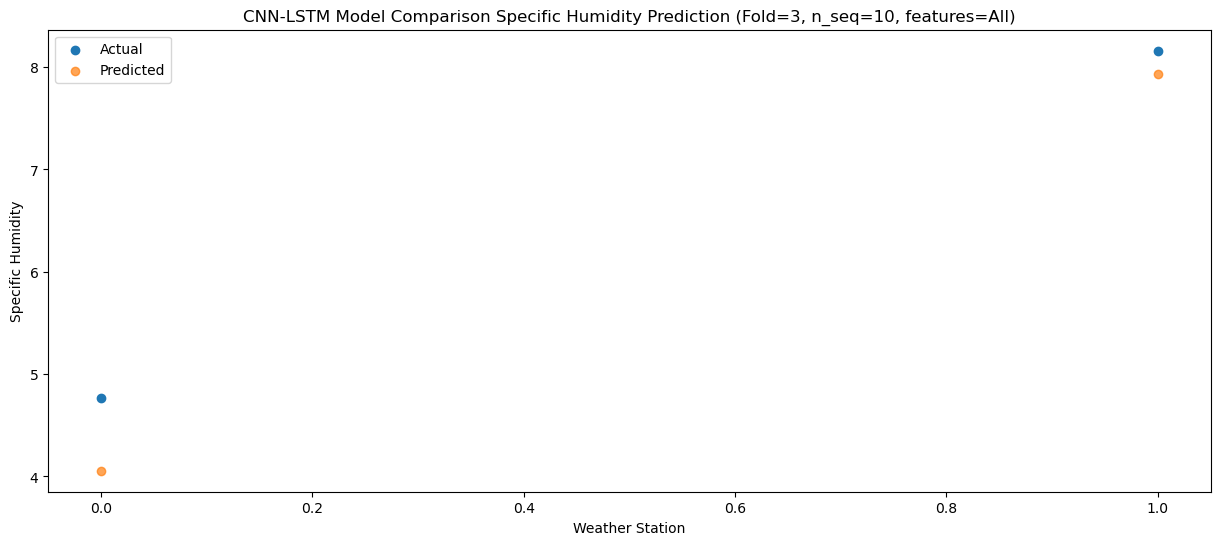

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.224707
1                1    8.18   8.105780


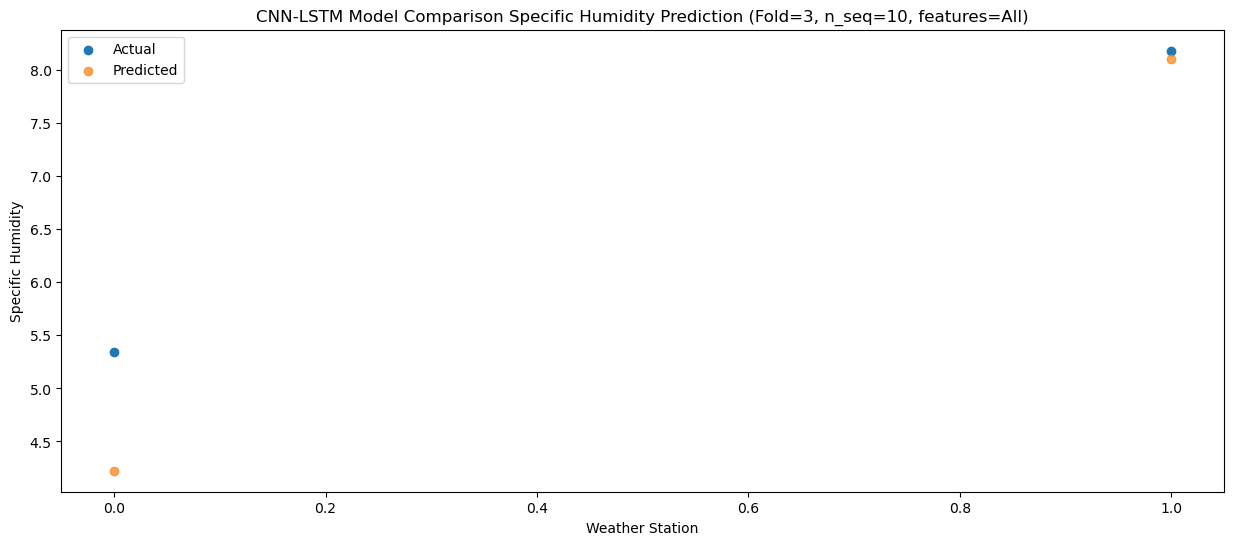

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.26088167 8.14101821]
 [4.81959296 8.69987834]
 [4.73208944 8.61237283]
 [4.74553245 8.62592883]
 [4.82524043 8.70569044]
 [4.4464569  8.32683748]
 [4.32817772 8.2087176 ]
 [4.38632607 8.26708599]
 [4.05600816 7.9368399 ]
 [4.2247067  8.10577987]]
Year at t+1:
t+1 SKRMSE: 0.485245
t+1 KRMSE: 0.485245
t+1 MAE: 0.425068
t+1 SKMAPE: 0.078997
t+1 R2_SCORE: 0.897412
t+1 KMAPE: 0.078997
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.212957
t+2 KRMSE: 0.212957
t+2 MAE: 0.195143
t+2 SKMAPE: 0.033887
t+2 R2_SCORE: 0.985107
t+2 KMAPE: 0.033887
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.156928
t+3 KRMSE: 0.156928
t+3 MAE: 0.142769
t+3 SKMAPE: 0.025510
t+3 R2_SCORE: 0.992995
t+3 KMAPE: 0.025510
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.602729
t+4 KRMSE: 0.6027

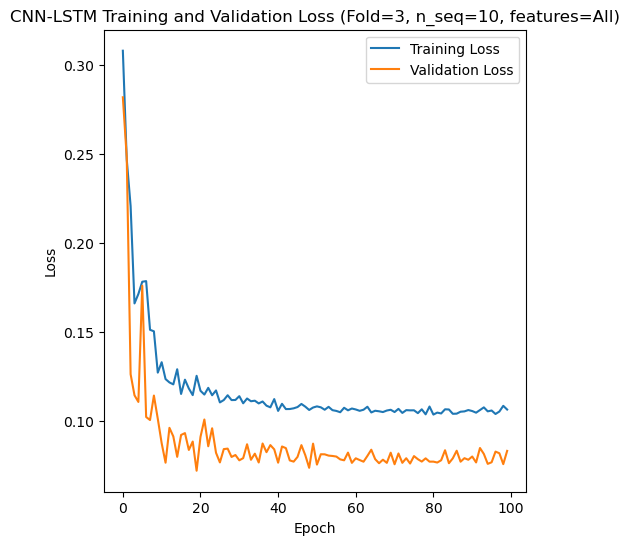

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 41s 629ms/step - loss: 0.2234 - accuracy: 0.3684 - mae: 0.1988 - rmse: 0.2234 - mape: 45.5757 - pearson: 0.1985 - val_loss: 0.1046 - val_accuracy: 0.0000e+00 - val_mae: 0.0843 - val_rmse: 0.1046 - val_mape: 19.3754 - val_pearson: 0.0282
Epoch 2/100
19/19 [==============================] - 3s 147ms/step - loss: 0.1688 - accuracy: 0.3684 - mae: 0.1464 - rmse: 0.1688 - mape: 33.7113 - pearson: 0.2420 - val_loss: 0.1957 - val_accuracy: 0.0000e+00 - val_mae: 0.1795 - val_rmse: 0.1957 - val_mape: 39.6736 - val_pearson: 0.2108
Epoch 3/100
19/19 [==============================] - 3s 137ms/step - loss: 0.1681 -

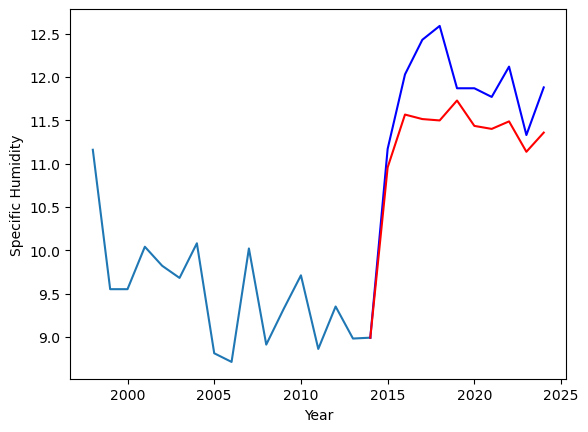

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		8.13		0.06
8.73		8.74		0.01
9.20		8.68		-0.52
8.87		8.67		-0.20
9.27		8.90		-0.37
8.73		8.61		-0.12
8.46		8.57		0.11
8.79		8.66		-0.13
8.19		8.31		0.12
8.42		8.53		0.11


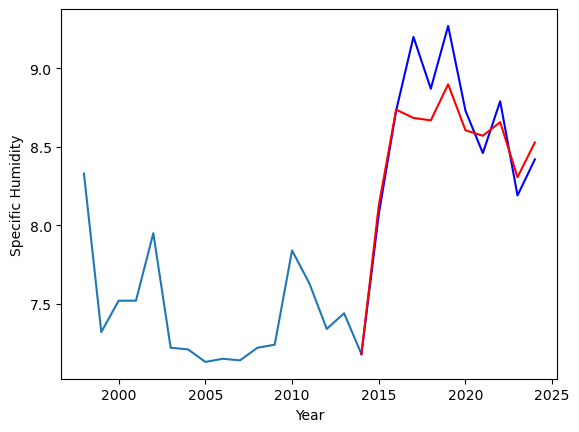

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  10.956149
1                1    8.07   8.126065


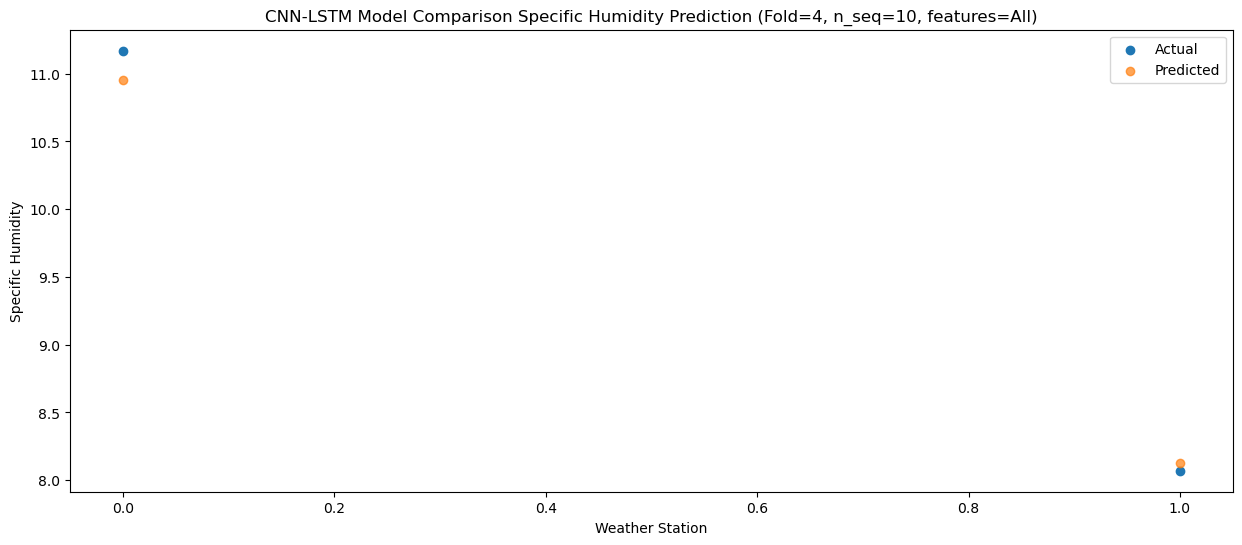

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  11.566385
1                1    8.73   8.736318


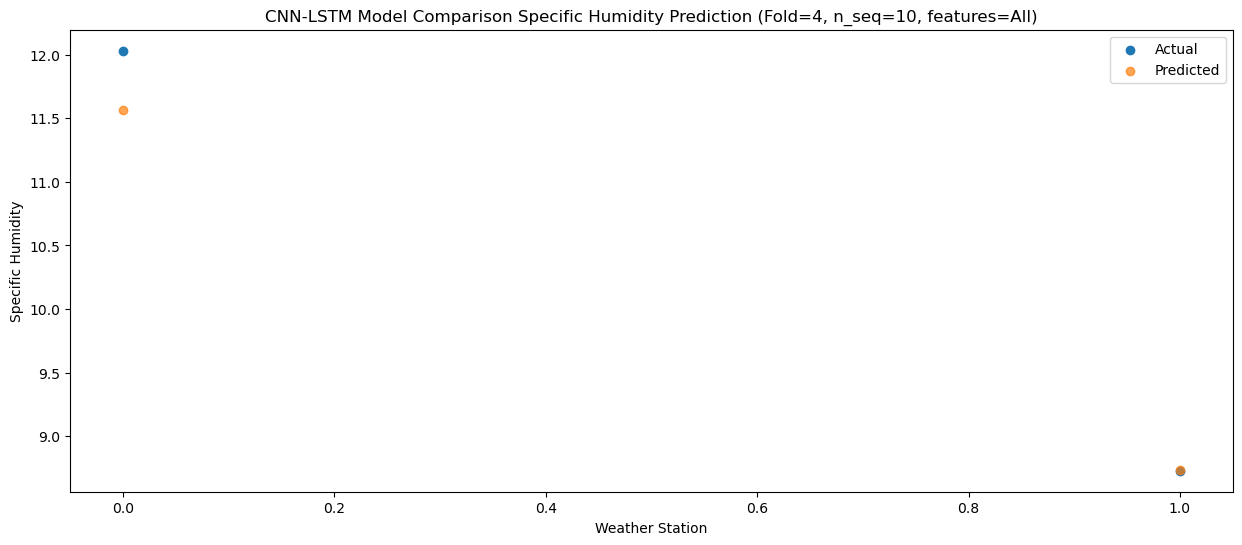

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.514381
1                1    9.20   8.684201


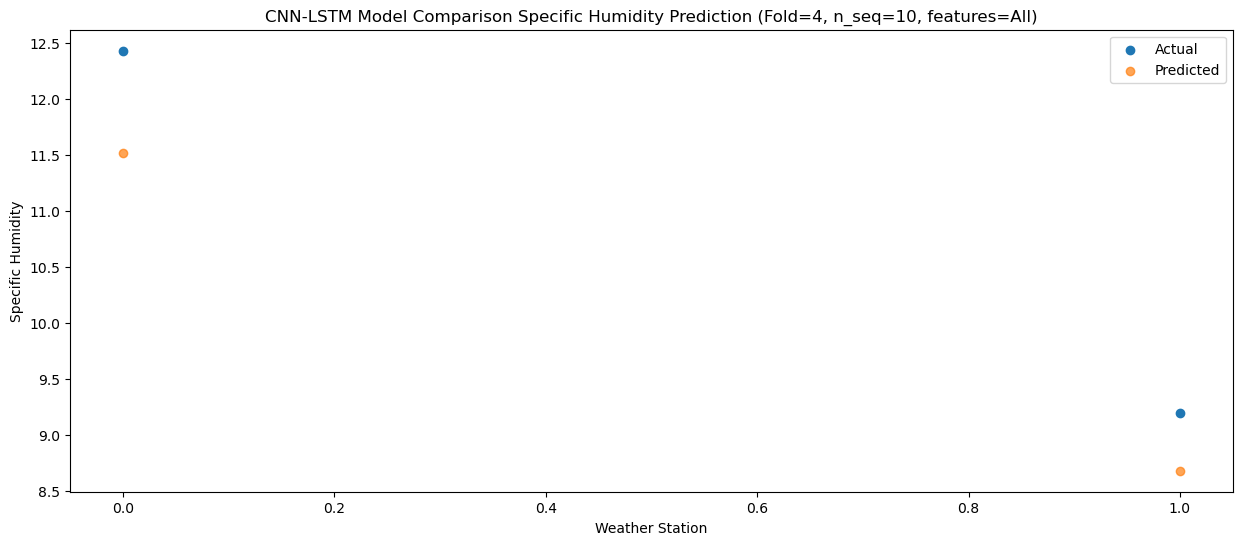

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.498529
1                1    8.87   8.668259


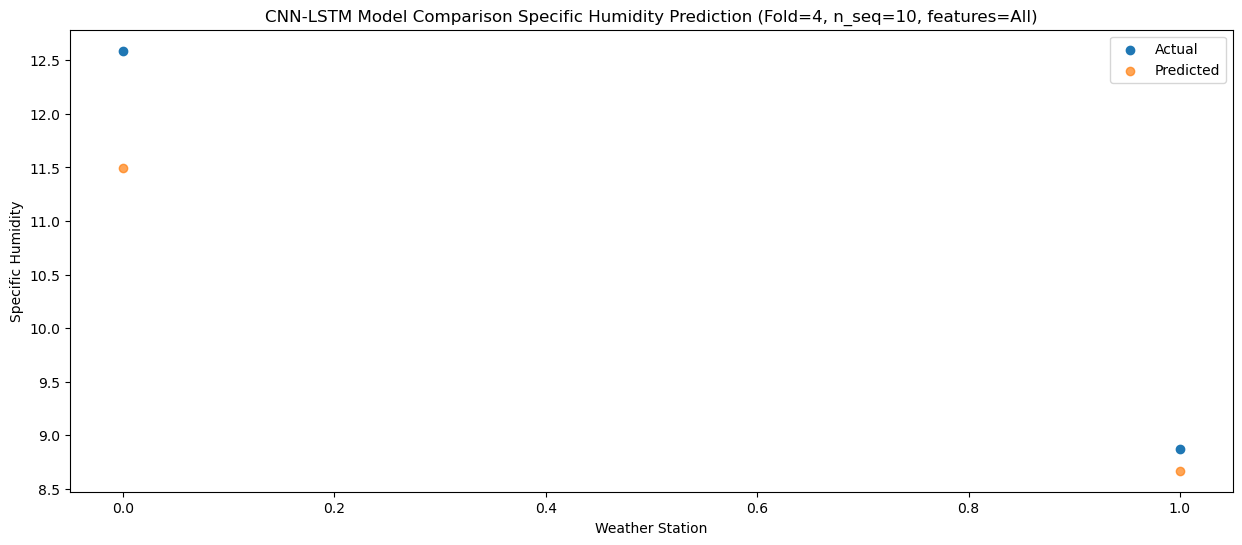

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.728537
1                1    9.27   8.898230


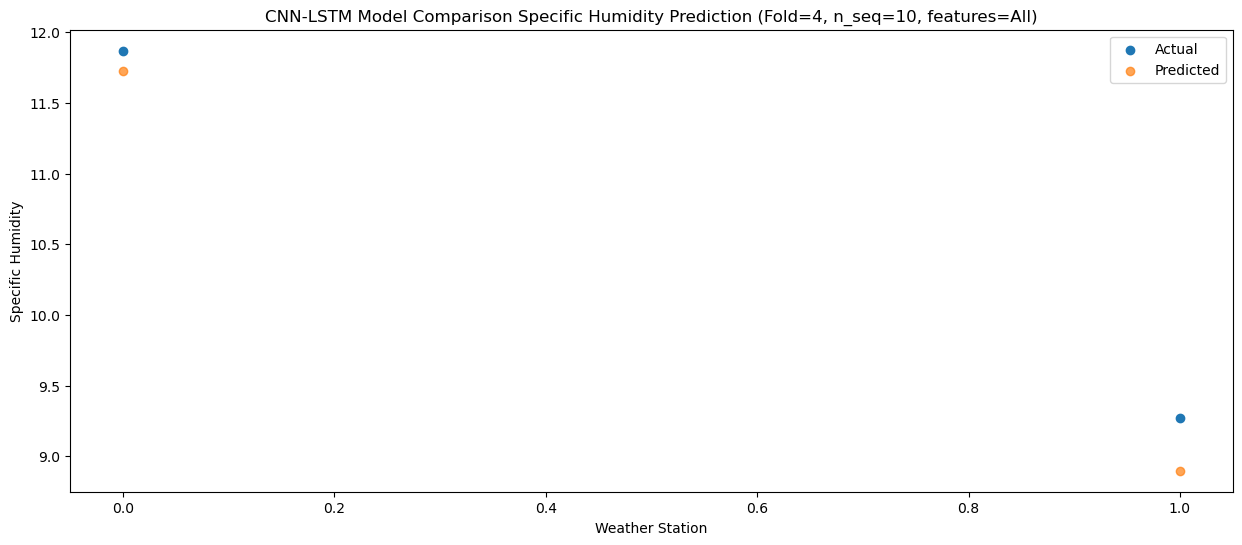

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.435512
1                1    8.73   8.605204


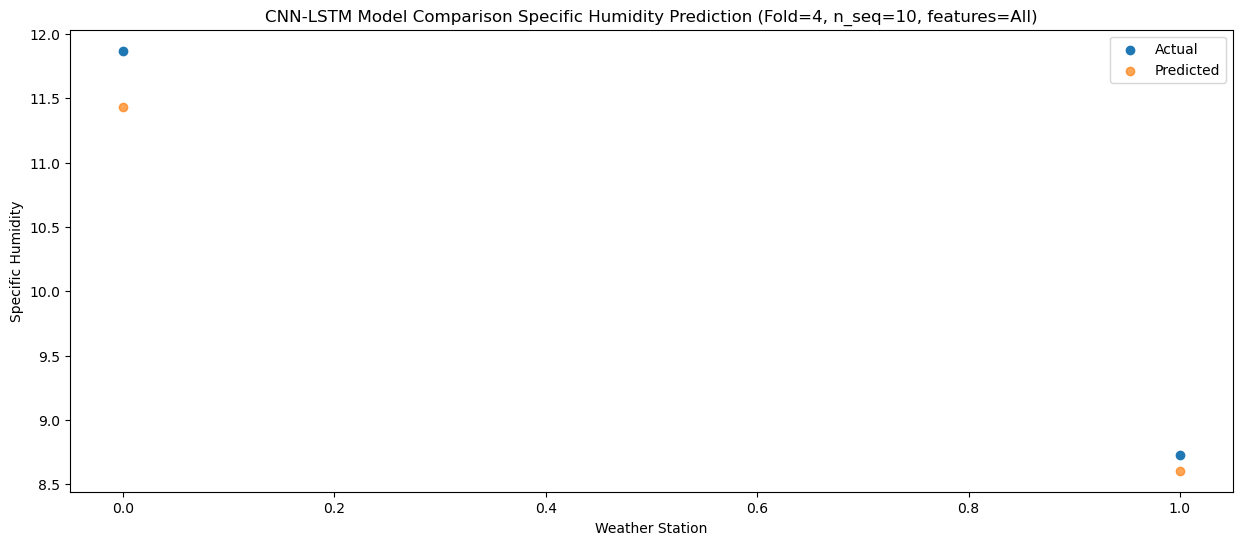

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.400801
1                1    8.46   8.570479


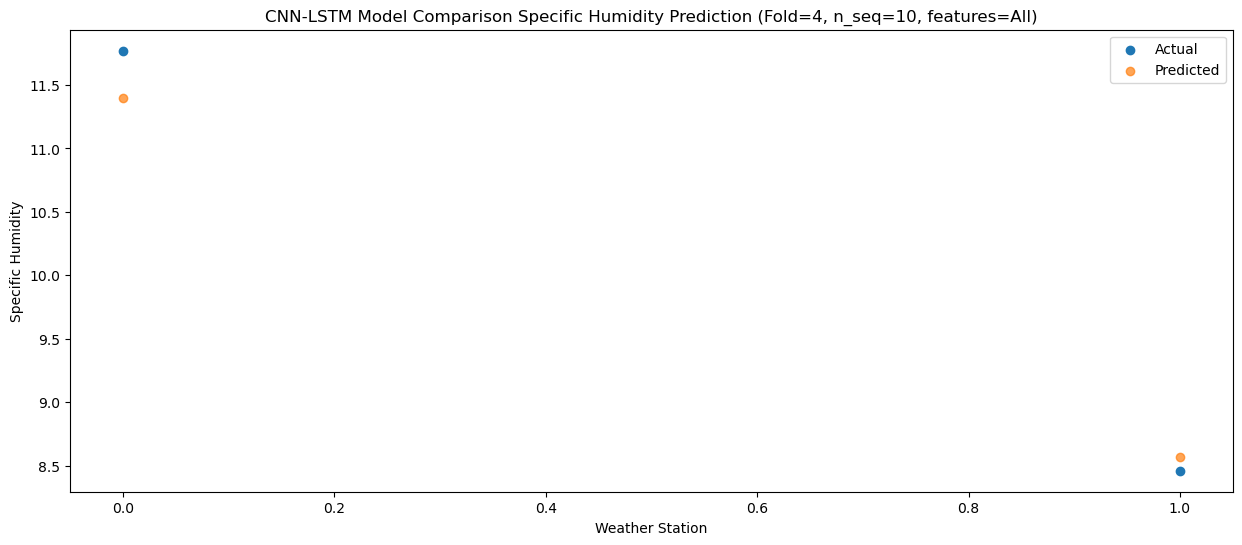

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.487612
1                1    8.79   8.657270


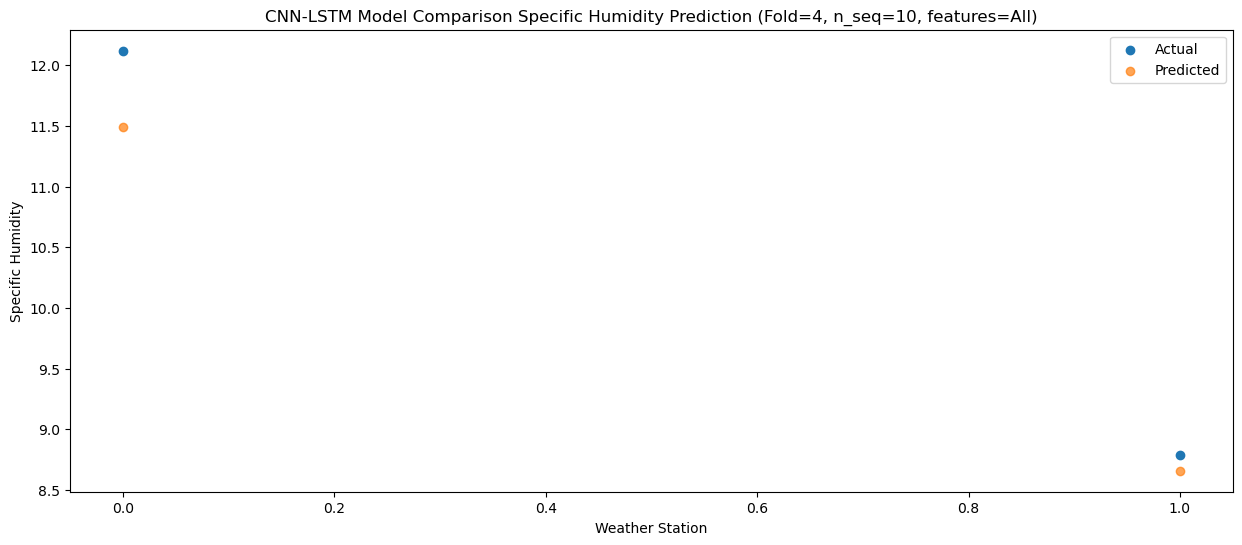

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.136729
1                1    8.19   8.306401


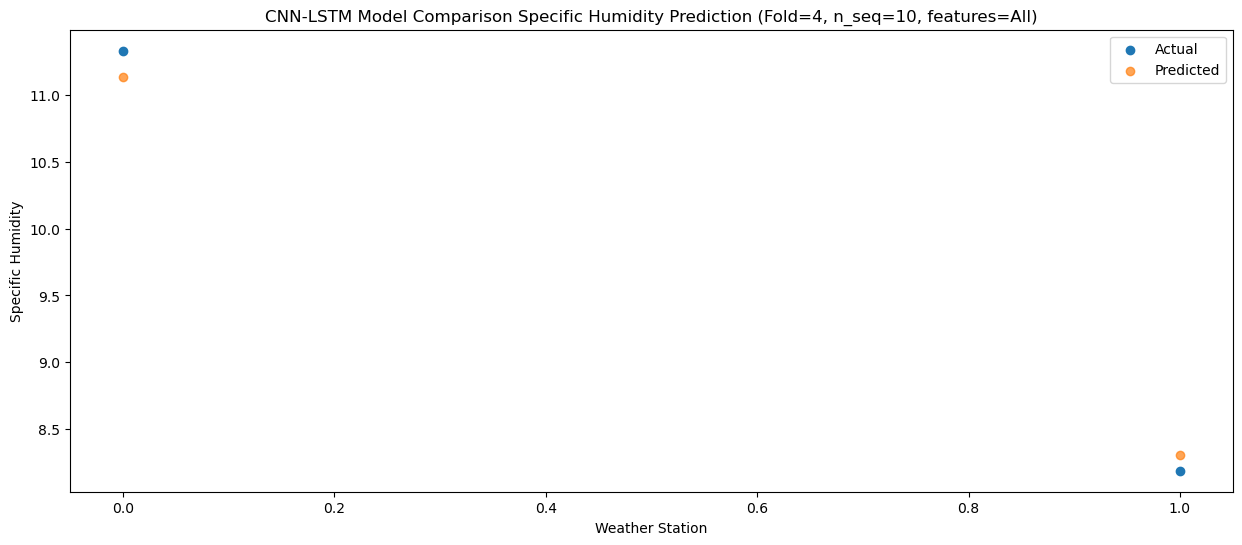

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.358157
1                1    8.42   8.527753


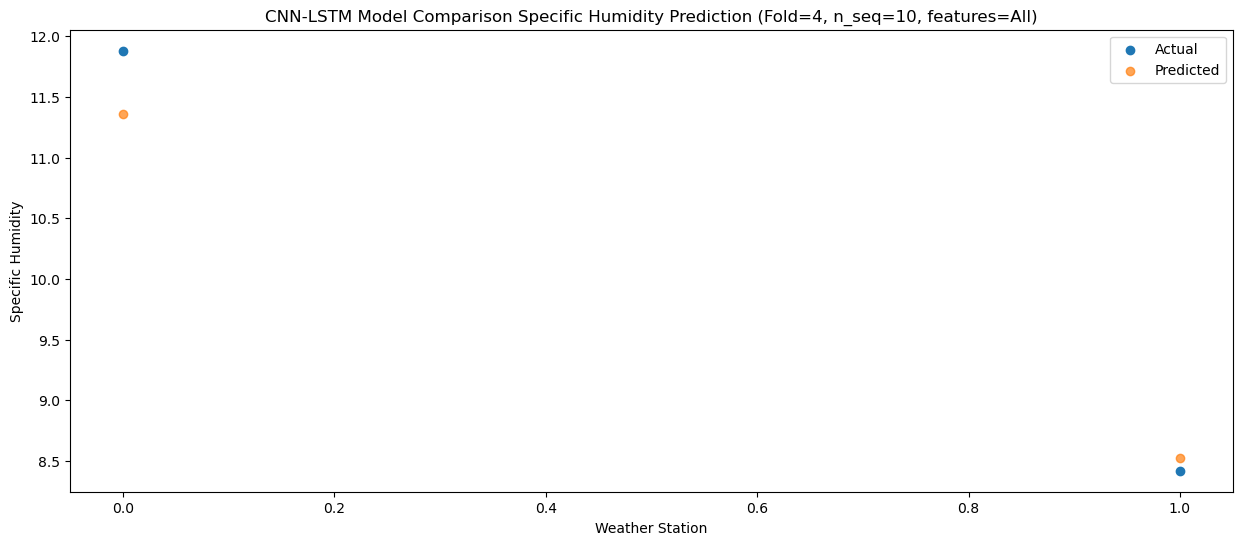

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[10.95614927  8.12606529]
 [11.56638532  8.73631826]
 [11.51438101  8.68420096]
 [11.49852881  8.66825902]
 [11.72853693  8.89822994]
 [11.43551215  8.60520421]
 [11.40080062  8.57047927]
 [11.48761158  8.65726986]
 [11.13672911  8.30640148]
 [11.35815664  8.52775309]]
Year at t+1:
t+1 SKRMSE: 0.156326
t+1 KRMSE: 0.156326
t+1 MAE: 0.134958
t+1 SKMAPE: 0.013046
t+1 R2_SCORE: 0.989828
t+1 KMAPE: 0.013046
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.327856
t+2 KRMSE: 0.327856
t+2 MAE: 0.234966
t+2 SKMAPE: 0.019631
t+2 R2_SCORE: 0.960518
t+2 KMAPE: 0.019631
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.743104
t+3 KRMSE: 0.743104
t+3 MAE: 0.715709
t+3 SKMAPE: 0.064864
t+3 R2_SCORE: 0.788284
t+3 KMAPE: 0.064864
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

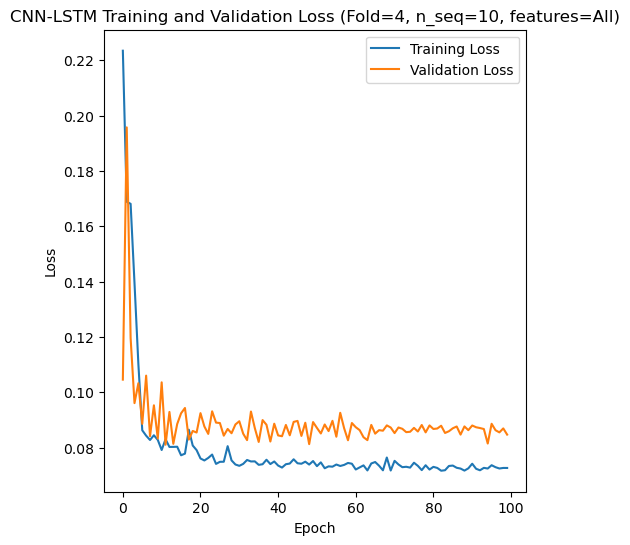

[[0.5775496100738127], [0.49928735488352427], [0.46542947458608114], [0.5810465392659567], [0.4395297712225811]]
[[array(0.57754961)], [array(0.49928735)], [array(0.46542947)], [array(0.58104654)], [array(0.43952977)]]
[[0.4976493058949714], [0.40118966048955923], [0.39691725872456973], [0.4624244378320873], [0.336053098309785]]
[[0.04047037524818288], [0.04111275764326266], [0.04336011997053927], [0.08001210968777688], [0.03035696016480422]]
[[0.8602877954079827], [0.9316610035022806], [0.818879504112707], [0.8800981791548507], [0.9302068337656215]]
[[array(0.04047038)], [array(0.04111276)], [array(0.04336012)], [array(0.08001211)], [array(0.03035696)]]
[[array(0.96091738)], [array(0.95810938)], [array(0.91877463)], [array(0.97514744)], [array(0.97871594)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8.26

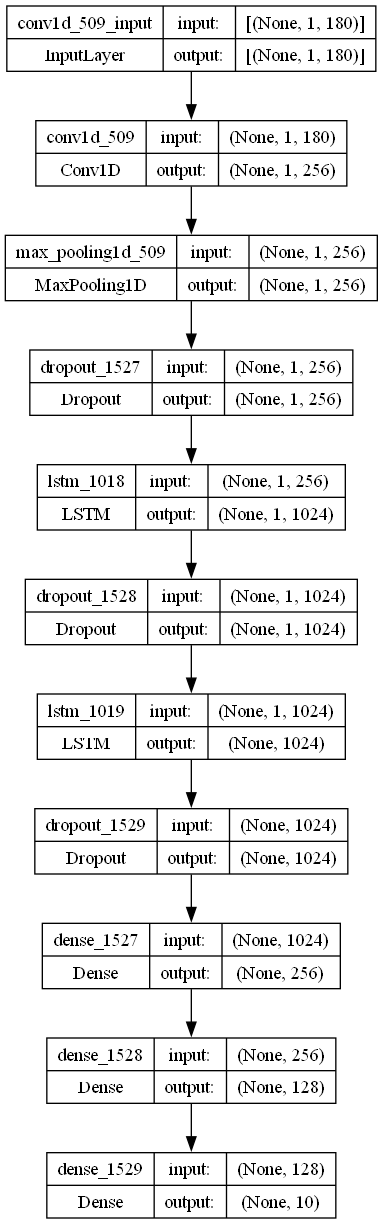

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.003155229404932366
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 1024
    dropout_rate = 0.4111116165730738

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S10.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)